# **Breast Cancer Detection Model**

### Data Wizards: Fernanda Vazquez, Aojie Li, Zixuan Tong, Muge Deng

## Objective:

Build a PoC (proof-of-concept) for a model to detect breast cancer with a focus on minimizing false negatives.

## Variable Description:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. Overall, there are 30 features, each describing the mean/error/worst of the 10 cell nucleus characteristic.

1) ID number
2) Diagnosis (M = malignant, B = benign)
3) Ten real-valued features are computed for each cell nucleus:
   
	a) radius (mean of distances from center to points on the perimeter)

	b) texture (standard deviation of gray-scale values)

	c) perimeter

	d) area

	e) smoothness (local variation in radius lengths)

	f) compactness (perimeter^2 / area - 1.0)

	g) concavity (severity of concave portions of the contour)

	h) concave points (number of concave portions of the contour)

	i) symmetry 

	j) fractal dimension ("coastline approximation" - 1)

## Assumptions:

1) Independence between all the observations in the dataset.
2) The data is representative of the CureAllCancers company’s target population. 
3) Model Development is valid in a real world setting within a testing device.

## Benchmark Baseline Model Performance:
UC Irvine ML Repository of Breast Cancer Wisconsin Diagnostic "constructed a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes" [K. P. Bennett, Decision Tree Construction Via Linear Programming. Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992].

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic


# 1. Import libraries, datasets, and global variables

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import zscore, ks_2samp
from itertools import combinations
import shap
from copy import deepcopy
from tabulate import tabulate
import warnings
from sklearn.exceptions import ConvergenceWarning

import sklearn
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

#For replication purposes, we list the versions used:
#1. NumPy version: 1.25.2
#2. Pandas version: 2.0.3
#3. Matplotlib version: 3.7.2
#4. Scikit-learn version: 1.3.1

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)

#Import Wisconsin dataset
from sklearn.datasets import load_breast_cancer
df_cancer = load_breast_cancer(as_frame=True)

#Global variables
RANDOM_STATE = 11
ID_LABELS = ['ID']
TARGET_LABEL = "target"
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1
BALANCED_RATE = 0.25

#Data preprocessing variables
HIGHLY_MISSING_THRESHOLD = 0.6
HIGHLY_CONCENTRATED_THRESHOLD = 0.9
Z_SCORE_THRESHOLD = 3.5
CAP_PERCENTILE_THRESHOLD = 0.99
FLOOR_PERCENTILE_THRESHOLD = 0.01
NUM_WOE_QUANTILES=3
IV_THRESHOLD = 0.05
CORRELATION_FILTER = 0.55

# Model tolerance levels
MIN_AUROC_VAL = 0.85
MAX_TARGET_PD_DIFF = 0.05
MAX_AUROC_TRAIN_VAL_DIFF = 0.10

#Hyperparameters
XGBOOST_MAX_DEPTH = 3
XGBOOST_N_ESTIMATORS=[50, 100, 200]
RF_N_ESTIMATORS = [50, 100, 200]


NumPy version: 1.25.2
Pandas version: 2.0.3
Matplotlib version: 3.7.2
Scikit-learn version: 1.3.1


We visualize the dat type of each variable. We confirm we only have numerical variables type floating-point number, which means it is a number that has a decimal place. For the target feature, it is stored as integer with only two values: 0 and 1.

In [2]:
df_cancer['data'].dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [3]:
df_cancer['target'].dtypes

dtype('int32')

In [4]:
df_cancer['target'].unique()

array([0, 1])

# 2. Data Treatment

## 2.a) Datasets merge: dependent variables and target/independent variable 

In [5]:
# Join both datasets ordered by ID.
df_extraction = pd.concat([df_cancer['data'],df_cancer['target']],axis=1)
df_extraction.insert(0, 'ID', range(1, len(df_extraction) + 1))

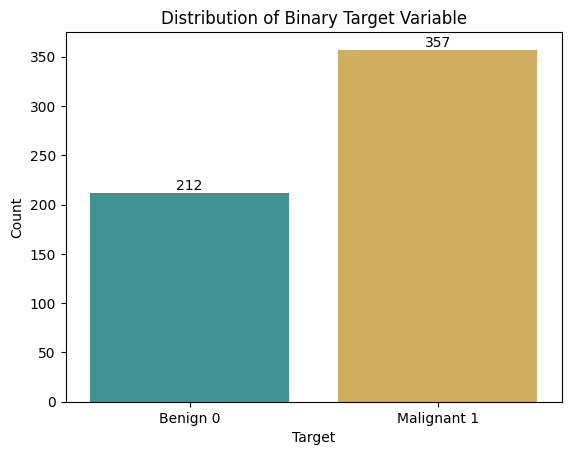

In [6]:
# Plotting the count values per category in the binary target
count_values = df_extraction['target'].value_counts()
sns.countplot(x='target', hue='target', data=df_extraction, palette=['darkcyan','goldenrod'], legend=False, alpha = 0.8)
plt.title('Distribution of Binary Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Benign 0', 'Malignant 1'])
class_labels = df_extraction['target'].unique()
for i, label in enumerate(class_labels):
    plt.text(i, count_values[i], f'{count_values[i]}', ha='center', va='bottom')
plt.show()

### Target variable distribution
Regarding our target variable, we have an unbalanced distribution with 37% benign and 63% malignant. The cancer rate is high since it represents the probability of breast cancer within the population of potential patients, but it does not represent the actual breast cancer rate in the whole population.

## 2.b) Split to training, validation, and testing

In [7]:
# Split the data into 80% training, 10% validation and 10% testing

df_extraction_train, df_extraction_val_test = train_test_split(df_extraction, train_size=TRAIN_FRAC, 
                                                               random_state=RANDOM_STATE, stratify=df_extraction[TARGET_LABEL])
df_extraction_val, df_extraction_test = train_test_split(df_extraction_val_test, 
                                                         train_size=VAL_FRAC/(VAL_FRAC+TEST_FRAC), random_state=11,
                                                         stratify=df_extraction_val_test[TARGET_LABEL])
print(f"Extraction size = {df_extraction.shape}. Target rate = {df_extraction[TARGET_LABEL].mean()}.")
print(f"Train size = {df_extraction_train.shape}. Target rate = {df_extraction_train[TARGET_LABEL].mean()}.")
print(f"Val size = {df_extraction_val.shape}. Target rate = {df_extraction_val[TARGET_LABEL].mean()}.")
print(f"Test size = {df_extraction_test.shape}. Target rate = {df_extraction_test[TARGET_LABEL].mean()}")

Extraction size = (569, 32). Target rate = 0.6274165202108963.
Train size = (455, 32). Target rate = 0.6263736263736264.
Val size = (57, 32). Target rate = 0.631578947368421.
Test size = (57, 32). Target rate = 0.631578947368421


In [8]:
# For backtesting purposes, we create a balanced testing dataset to validate the final model with a lower target rate, 25%.

df_negative = df_extraction_test[df_extraction_test[TARGET_LABEL] == 0]
df_positive = df_extraction_test[df_extraction_test[TARGET_LABEL] == 1]

df_positive_upsampled = resample(df_positive,
                                 replace=True,
                                 n_samples=int(np.round(len(df_negative) * BALANCED_RATE/(1-BALANCED_RATE))),
                                 random_state=RANDOM_STATE)

# Combine majority class with upsampled minority class
df_extraction_test_bal = pd.concat([df_negative, df_positive_upsampled])

# Shuffle the dataset
df_extraction_test_bal = df_extraction_test_bal.sample(frac=1, random_state=RANDOM_STATE)

# Print the new positive rate
print(f"Balanced test size = {df_extraction_test_bal.shape}. Target rate = {df_extraction_test_bal[TARGET_LABEL].mean()}.")

Balanced test size = (28, 32). Target rate = 0.25.


## 2.c) Treat missing values (based on training)

We remove features with more than 60% of missing values. No features were removed because as confirmed below, there are not missing values in our dataset.

In [9]:
# Create a table showing the % of missing values per feature
df_missing = pd.DataFrame(
        {"variable": df_extraction_train.columns, 
         "%_missing": df_extraction_train.isnull().sum() / df_extraction_train.shape[0]}
    )
df_missing = df_missing.sort_values(by=["%_missing", "variable"], ascending=[False, True]).reset_index(drop=True)
display(df_missing.head())

# Remove those features with more than 60% of their values as missing.
features_highly_missing = df_missing[(df_missing["%_missing"] >= HIGHLY_MISSING_THRESHOLD)&(~df_missing["variable"].isin(ID_LABELS))]["variable"].tolist()
keep_features = [x for x in df_extraction_train.columns if x not in features_highly_missing]
df_train_trt1 = df_extraction_train[keep_features].copy()
df_val_trt1 = df_extraction_val[keep_features].copy()
df_test_trt1 = df_extraction_test[keep_features].copy()
df_test_bal_trt1 = df_extraction_test_bal[keep_features].copy()

n_features_removed = df_extraction_train.shape[1] - df_train_trt1.shape[1]
print(f"Size of train after removal = {df_train_trt1.shape}.")
print(f"# features removed = {n_features_removed}.")

,variable,%_missing
0,ID,0.0
1,area error,0.0
2,compactness error,0.0
3,concave points error,0.0
4,concavity error,0.0


Size of train after removal = (455, 32).
# features removed = 0.


In [10]:
# We confirmn non-existence of missing values in our nadaset
missing_values = df_extraction_train.isnull().sum()
print("Columns with missing values on training:")
print(missing_values[missing_values > 0])

Columns with missing values on training:
Series([], dtype: int64)


## 2.d) Non-numerical variables

As shown in section 2.a, we only have numerical variables. None transformations are needed and we propose to maintain the scheme and nature of the original dataset.

In [11]:
# Identify non-numerical columns
numerical_columns = df_train_trt1.select_dtypes(include=['number']).columns
non_numerical_columns = df_train_trt1.select_dtypes(exclude=['number']).columns
non_numerical_columns

Index([], dtype='object')

## 2.e) Remove features below highly_concentrated_threshold

The next step is to remove variables with very repetitive values that make it lose explanatory power. Based on the training dataset, we observe that maximum concentration value is 0 for the first six variables in the table. However, the concentration rate is only $2.64\%$ which is lower than our threshold of $90\%$.

In [12]:
# Create a table with the most concentraed value per variable
df_most_concentrated = {"variable": [], "values_with_most_concentration": [], "concentration": []}
features = [x for x in df_train_trt1.columns if x not in ID_LABELS + [TARGET_LABEL]]
for feature in features:
    value_counts_num = df_train_trt1[feature].value_counts()
    max_count = value_counts_num.max()
     
    df_most_concentrated["variable"].append(feature)
    
    values_with_most_concentration = value_counts_num[value_counts_num==max_count].index.tolist()
    df_most_concentrated["values_with_most_concentration"].append(values_with_most_concentration)
    
    concentration = max_count / value_counts_num.sum()
    df_most_concentrated["concentration"].append(concentration)

df_most_concentrated = (pd.DataFrame
                        .from_dict(df_most_concentrated)
                        .sort_values(by=["concentration", "variable"], ascending=[False, True])
                        .reset_index(drop=True))

# Remove those variables exceeding the 90% threshold
mask = ((df_most_concentrated["concentration"] >= HIGHLY_CONCENTRATED_THRESHOLD)&(~df_missing["variable"].isin(ID_LABELS)))
features_most_concentration = df_most_concentrated[mask]["variable"].tolist()

keep_features = [x for x in df_train_trt1.columns if x not in features_most_concentration]
df_train_trt2 = df_train_trt1[keep_features].copy()
df_val_trt2 = df_val_trt1[keep_features].copy()
df_test_trt2 = df_test_trt1[keep_features].copy()
df_test_bal_trt2 = df_test_bal_trt1[keep_features].copy()

n_features_removed = df_train_trt1.shape[1] - df_train_trt2.shape[1]
print(f"Size of train after removal = {df_train_trt2.shape}.")
print(f"# features removed = {n_features_removed}.")
df_most_concentrated.head(10)

Size of train after removal = (455, 32).
# features removed = 0.


Boolean Series key will be reindexed to match DataFrame index.


,variable,values_with_most_concentration,concentration
0,concave points error,[0.0],0.026374
1,concavity error,[0.0],0.026374
2,mean concave points,[0.0],0.026374
3,mean concavity,[0.0],0.026374
4,worst concave points,[0.0],0.026374
5,worst concavity,[0.0],0.026374
6,worst radius,[12.36],0.010989
7,mean radius,[12.34],0.008791
8,mean smoothness,[0.1007],0.008791
9,mean symmetry,"[0.1717, 0.1714]",0.008791


## 2.f) Conduct outlier identification

Based on the training dataset, we identify variables with observations above 3.5 z-score, which measures the number of standard deviations from the mean. Out of the 30 variables, 28 contained outliers. We also tried Tukey Fences or IQR procedure for identifying outliers, but the lower bound results in negative values which are never reached in our dataset.

In [13]:
df_numeric_features = df_train_trt2.drop(columns=ID_LABELS + [TARGET_LABEL])

# Calculate z-scores for each numeric feature and obtain the maximun
z_scores = df_train_trt2.drop(columns=ID_LABELS + [TARGET_LABEL]).apply(zscore)
max_abs_z_scores = z_scores.abs().max()

# Create a DataFrame to store variable names and their maximum absolute z-scores
df_outliers = pd.DataFrame({
    "variable": max_abs_z_scores.index,
    "max_abs_z_score": max_abs_z_scores.values
})

df_outliers = df_outliers.sort_values(by=["max_abs_z_score", "variable"], ascending=[False, True]).reset_index(drop=True)

# Filter out variables with maximum absolute z-score above the threshold
df_outliers = df_outliers[df_outliers["max_abs_z_score"] >= Z_SCORE_THRESHOLD].reset_index(drop=True)

# Count the number of observations above the z-score threshold for each variable
num_observations_above_threshold = []
total_observations = len(z_scores)
for variable in df_outliers["variable"]:
    num_above_threshold = (z_scores[variable].abs() > Z_SCORE_THRESHOLD).sum()
    num_observations_above_threshold.append(num_above_threshold)

proportion_observations_above_threshold = [num / total_observations for num in num_observations_above_threshold]

# Add the number of observations above the threshold and proportion to the DataFrame
df_outliers["num_observations_above_threshold"] = num_observations_above_threshold
df_outliers["proportion_above_threshold"] = proportion_observations_above_threshold

display(df_outliers.head(10))

features_with_outliers = df_outliers["variable"].tolist()

print(f"# features with outliers = {df_outliers.shape[0]}.")


,variable,max_abs_z_score,num_observations_above_threshold,proportion_above_threshold
0,area error,10.686235,4,0.008791
1,concavity error,10.130420,4,0.008791
2,perimeter error,9.381914,4,0.008791
3,radius error,8.914010,3,0.006593
4,smoothness error,7.907565,5,0.010989
5,fractal dimension error,7.553289,5,0.010989
6,symmetry error,7.235163,6,0.013187
7,texture error,6.656481,4,0.008791
8,worst fractal dimension,6.587440,2,0.004396
9,compactness error,5.998404,5,0.010989


# features with outliers = 28.


### Tukey Fences or IQR procedure

In [14]:
# Calculate the first quartile (Q1), third quartile (Q3), and IQR for each numeric feature
#Q1 = df_train_trt2.drop(columns=ID_LABELS + [TARGET_LABEL]).quantile(0.25)
#Q3 = df_train_trt2.drop(columns=ID_LABELS + [TARGET_LABEL]).quantile(0.75)
#IQR = Q3 - Q1

# Compute the upper and lower bounds for outlier detection
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR

# Create a DataFrame to store variable names and their maximum absolute z-scores
#df_outliers = pd.DataFrame({
#    "variable": lower_bound.index,
#    "lower_bound": lower_bound.values,
#    "upper_bound": upper_bound.values
#})

# Sort the DataFrame by variable name
#df_outliers = df_outliers.sort_values(by=["variable"]).reset_index(drop=True)

# Filter out variables with outliers
#df_outliers = df_outliers[(df_outliers["lower_bound"] < df_outliers["upper_bound"])].reset_index(drop=True)

# Display the DataFrame with variables and their bounds
#display(df_outliers)

## 2.g) Conduct outlier treatment

We use a conservative floor and cap of 1% and 99% correspondingly to avoid any bias.

In [15]:
floor_label = f"floor_percentile_{100*FLOOR_PERCENTILE_THRESHOLD}%"
cap_label = f"cap_percentile_{100*CAP_PERCENTILE_THRESHOLD}%"

# Generate the floor and cap per feature
df_outliers_quantiles = (df_numeric_features[features_with_outliers]
                         .quantile([FLOOR_PERCENTILE_THRESHOLD, 
                                    CAP_PERCENTILE_THRESHOLD], interpolation="nearest")
                         .T
                         .reset_index())
df_outliers_quantiles.columns = ["variable", floor_label, cap_label]

df_train_trt3 = df_train_trt2.copy()
df_val_trt3 = df_val_trt2.copy()
df_test_trt3 = df_test_trt2.copy()
df_test_bal_trt3 = df_test_bal_trt2.copy()

# Create a table for comparison of the minimum and maximum per feature after the treatment
dict_before_after_report = {"variable": [], floor_label: [], cap_label: [],
                            "min_before_trt": [], "max_before_trt": [], "min_after_trt": [], "max_after_trt": []}
for feature in df_outliers_quantiles["variable"]:
    mask = df_outliers_quantiles["variable"] == feature
    floor_value, cap_value = df_outliers_quantiles[mask][[floor_label, cap_label]].iloc[0]
    
    df_train_trt3[feature] = np.select([df_train_trt3[feature]<floor_value, df_train_trt3[feature]>=cap_value],
                                       [floor_value, cap_value], default=df_train_trt3[feature])
    df_val_trt3[feature] = np.select([df_val_trt3[feature]<floor_value, df_val_trt3[feature]>=cap_value],
                                     [floor_value, cap_value], default=df_val_trt3[feature])
    df_test_trt3[feature] = np.select([df_test_trt3[feature]<floor_value, df_test_trt3[feature]>=cap_value],
                                      [floor_value, cap_value], default=df_test_trt3[feature])
    df_test_bal_trt3[feature] = np.select([df_test_bal_trt3[feature]<floor_value, df_test_bal_trt3[feature]>=cap_value],
                                      [floor_value, cap_value], default=df_test_bal_trt3[feature])
    
    dict_before_after_report["variable"].append(feature)
    dict_before_after_report[floor_label].append(floor_value)
    dict_before_after_report[cap_label].append(cap_value)
    dict_before_after_report["min_before_trt"].append(df_train_trt2[feature].min())
    dict_before_after_report["max_before_trt"].append(df_train_trt2[feature].max())
    dict_before_after_report["min_after_trt"].append(df_train_trt3[feature].min())
    dict_before_after_report["max_after_trt"].append(df_train_trt3[feature].max())

# Generate before after report
df_before_after_report = pd.DataFrame.from_dict(dict_before_after_report)
df_before_after_report

,variable,floor_percentile_1.0%,cap_percentile_99.0%,min_before_trt,max_before_trt,min_after_trt,max_after_trt
0,area error,8.955000,164.10000,7.254000,542.20000,8.955000,164.10000
1,concavity error,0.000000,0.11660,0.000000,0.30380,0.000000,0.11660
2,perimeter error,0.921900,9.63500,0.757000,21.98000,0.921900,9.63500
3,radius error,0.121000,1.20700,0.114400,2.87300,0.121000,1.20700
4,smoothness error,0.003169,0.01721,0.001713,0.03113,0.003169,0.01721
5,fractal dimension error,0.001217,0.01256,0.000968,0.02286,0.001217,0.01256
6,symmetry error,0.010570,0.05113,0.009539,0.07895,0.010570,0.05113
7,texture error,0.433400,2.91000,0.360200,4.88500,0.433400,2.91000
8,worst fractal dimension,0.059050,0.14090,0.055210,0.20750,0.059050,0.14090
9,compactness error,0.004693,0.08808,0.002252,0.13540,0.004693,0.08808


# 3. Variable selection

## 3.a) Conduct univariate variable selection

We focus on understanding the predictive power of a feature in relation to the target measured by Weight of Evidence. We apply WOE binning for each feature and calculate IV. We selected three quantiles to avoid having multiple IV infinite values as worst perimeter, since the number of events equal the number of observations in one bin. Setting a minimum threshold of 0.05 IV based on a rule of thumb, we only remove 4 variables.

In [16]:
feature_list = [x for x in df_train_trt3 if x not in ID_LABELS + [TARGET_LABEL]]
# Apply WOE binning for each feature and calculate IV
df_woe_iv = pd.DataFrame()
for feature in feature_list:
    df_agg = df_train_trt3[[TARGET_LABEL, feature]].copy()
    df_agg['bin']=pd.qcut(df_agg[feature], q=NUM_WOE_QUANTILES,duplicates='drop')
    df_agg = df_agg[['bin',TARGET_LABEL]].groupby('bin', observed = True).agg(['count', 'sum']).reset_index()
    n=df_agg.shape[0]
    df_agg.columns = ['bin','num_obs', 'num_events']
    df_agg.index = [feature]*n
    df_agg = df_agg.reset_index().rename(columns={'index':'variable'})
    df_agg['num_non_events']=df_agg['num_obs']-df_agg['num_events']
    sum_events = df_agg['num_events'].sum()
    sum_non_events = df_agg['num_non_events'].sum()
    df_agg['perc_events']=df_agg['num_events']/(sum_events+1e-9)
    df_agg['perc_non_events']=df_agg['num_non_events']/(sum_non_events+1e-9)

    df_agg['woe'] = np.log(df_agg['perc_events']/ df_agg['perc_non_events'])
    df_agg['iv_bin'] = (df_agg['perc_events']- df_agg['perc_non_events']) * df_agg['woe'] 
    df_agg['iv'] =  [df_agg['iv_bin'].sum()]*n 
    # Store results in the output DataFrame
    df_woe_iv = pd.concat([df_woe_iv, df_agg], ignore_index=True)

df_woe_iv = df_woe_iv.sort_values(by=["iv", "variable", "bin"], ascending=[False, True, True]).reset_index(drop=True)
display(df_woe_iv.head(10))

,variable,bin,num_obs,num_events,num_non_events,perc_events,perc_non_events,woe,iv_bin,iv
0,worst perimeter,"(58.359, 88.153]",152,152,0,0.533333,0.000000,inf,inf,inf
1,worst perimeter,"(88.153, 113.167]",151,122,29,0.428070,0.170588,0.920034,0.236892,inf
2,worst perimeter,"(113.167, 205.7]",152,11,141,0.038596,0.829412,-3.067555,2.425870,inf
3,worst concave points,"(-0.001, 0.0794]",152,151,1,0.529825,0.005882,4.500589,2.358049,5.646671
4,worst concave points,"(0.0794, 0.146]",151,127,24,0.445614,0.141176,1.149443,0.349933,5.646671
5,worst concave points,"(0.146, 0.29]",152,7,145,0.024561,0.852941,-3.547514,2.938689,5.646671
6,worst radius,"(9.261000000000001, 13.583]",152,151,1,0.529825,0.005882,4.500589,2.358049,5.040994
7,worst radius,"(13.583, 16.847]",151,123,28,0.431579,0.164706,0.963289,0.257076,5.040994
8,worst radius,"(16.847, 30.67]",152,11,141,0.038596,0.829412,-3.067555,2.425870,5.040994
9,mean concave points,"(-0.001, 0.0242]",152,151,1,0.529825,0.005882,4.500589,2.358049,4.918448


In [17]:
# Create a table sorting by IV
df_iv = df_woe_iv[['variable','iv']].groupby(by=['variable'],as_index=False).first().sort_values(by=["iv"], ascending=False)
display(df_iv.head())

# Keep features above the 0.05 IV threshold
features_high_iv = df_iv[df_iv['iv']>= IV_THRESHOLD]['variable'].tolist()

df_train_mdl1 = df_train_trt3[ID_LABELS +[TARGET_LABEL]+features_high_iv].copy()
df_val_mdl1 = df_val_trt3[ID_LABELS +[TARGET_LABEL]+features_high_iv].copy()
df_test_mdl1 = df_test_trt3[ID_LABELS+[TARGET_LABEL]+features_high_iv].copy()
df_test_bal_mdl1 = df_test_bal_trt3[ID_LABELS+[TARGET_LABEL]+features_high_iv].copy()

n_features_removed = df_train_trt3.shape[1] - df_train_mdl1.shape[1]
print(f"Size of train after removal = {df_train_mdl1.shape}.")
print(f"# features removed = {n_features_removed}.")

,variable,iv
25,worst perimeter,inf
22,worst concave points,5.646671
26,worst radius,5.040994
7,mean concave points,4.918448
20,worst area,4.918448


Size of train after removal = (455, 28).
# features removed = 4.


## 3.b) Conduct multivariate variable selection

We analyze each variable in relation to other variables to avoid redundancy. We look to minimize multicollinearity and maximizing predictive power.

In [18]:
# Calculate Spearman correlation for the numerical variables
feature_list = [x for x in df_train_mdl1.columns if x not in ID_LABELS + [TARGET_LABEL]]
df_corr = df_train_mdl1.corr(method='spearman').reset_index().rename(columns={'index':'variable'})
display(df_corr.head())

,variable,ID,target,worst perimeter,worst concave points,worst radius,mean concave points,worst area,mean concavity,mean perimeter,...,concavity error,worst texture,mean texture,compactness error,worst smoothness,worst symmetry,mean smoothness,mean symmetry,worst fractal dimension,fractal dimension error
0,ID,1.000000,0.286844,-0.144438,-0.189837,-0.146356,-0.175550,-0.144202,-0.176324,-0.099337,...,-0.091673,-0.042616,-0.012568,-0.089689,-0.197944,-0.239301,-0.157191,-0.178504,-0.157565,-0.079715
1,target,0.286844,1.000000,-0.803151,-0.796844,-0.793900,-0.786173,-0.792203,-0.750028,-0.749711,...,-0.497615,-0.503698,-0.490538,-0.432722,-0.421656,-0.400140,-0.374130,-0.353740,-0.335372,-0.253172
2,worst perimeter,-0.144438,-0.803151,1.000000,0.819163,0.992635,0.823986,0.991685,0.746324,0.977869,...,0.478107,0.393286,0.396117,0.401415,0.214599,0.273260,0.217266,0.208480,0.198914,0.118192
3,worst concave points,-0.189837,-0.796844,0.819163,1.000000,0.786533,0.942175,0.779129,0.916133,0.761125,...,0.690550,0.374791,0.339319,0.631807,0.528848,0.466573,0.488043,0.415184,0.528278,0.380821
4,worst radius,-0.146356,-0.793900,0.992635,0.786533,1.000000,0.797972,0.998729,0.705529,0.980778,...,0.423460,0.383620,0.387735,0.338786,0.192669,0.248063,0.195873,0.182852,0.144469,0.064592


The correlogram shows multiple dark red and dark blue squares, meaning there are features highly correlated. 

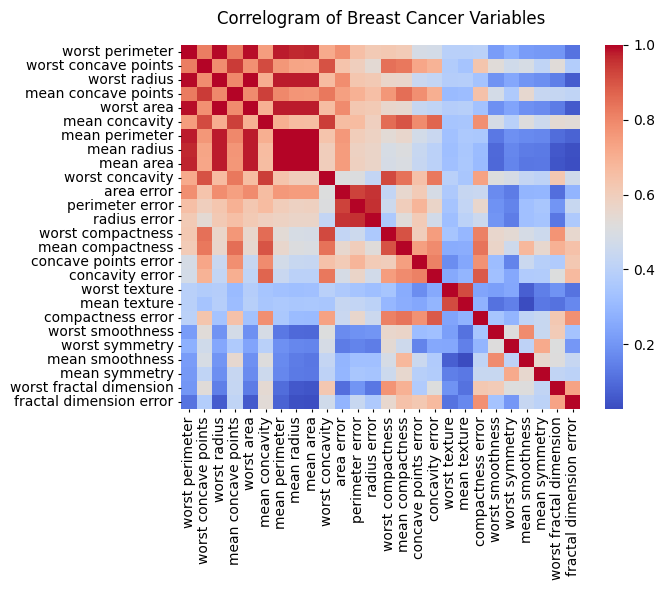

In [19]:
plt.figure(figsize=(7, 6))
df_train_corr = df_train_mdl1.copy().drop(columns=['ID', 'target'])
numerical_columns = df_train_corr.select_dtypes(include='number').columns
sns.heatmap(df_train_corr.corr(method='spearman'), cmap='coolwarm', annot=False, fmt=".2f", linewidths=0)
plt.tick_params(axis='both', which='both', length=2)
plt.xticks(rotation=90)
plt.title('Correlogram of Breast Cancer Variables', pad=15)
plt.tight_layout()
plt.show()

### **Prioritization table**

In [20]:
# Merge IV and Spearman correlation
df_iv_corr = pd.merge(df_iv, df_corr, on=["variable"], how="inner").sort_values(by=['iv'],ascending=False).reset_index(drop=True)

# Determine max absolute correlation with above features (sorted by IV importance) and flag to keep if at or below threshold.
max_abs_corr_list = []
keep_list = []
for i, feature in enumerate(df_iv_corr["variable"]):
    if i == 0:
        max_abs_corr = np.nan
    else:
        mask = df_iv_corr["variable"]==feature
        max_abs_corr = df_iv_corr[mask].iloc[0, 2:2+i].abs().max()
    max_abs_corr_list.append(max_abs_corr)
    keep_list.append(1 if max_abs_corr<CORRELATION_FILTER or np.isnan(max_abs_corr) else 0)

df_iv_corr.insert(loc=2, column="max_abs_corr", value=max_abs_corr_list)
df_iv_corr.insert(loc=3, column="keep_feature", value=keep_list)
df_iv_corr

,variable,iv,max_abs_corr,keep_feature,ID,target,worst perimeter,worst concave points,worst radius,mean concave points,...,concavity error,worst texture,mean texture,compactness error,worst smoothness,worst symmetry,mean smoothness,mean symmetry,worst fractal dimension,fractal dimension error
0,worst perimeter,inf,NaN,1,-0.144438,-0.803151,1.000000,0.819163,0.992635,0.823986,...,0.478107,0.393286,0.396117,0.401415,0.214599,0.273260,0.217266,0.208480,0.198914,0.118192
1,worst concave points,5.646671,0.189837,1,-0.189837,-0.796844,0.819163,1.000000,0.786533,0.942175,...,0.690550,0.374791,0.339319,0.631807,0.528848,0.466573,0.488043,0.415184,0.528278,0.380821
2,worst radius,5.040994,0.793900,0,-0.146356,-0.793900,0.992635,0.786533,1.000000,0.797972,...,0.423460,0.383620,0.387735,0.338786,0.192669,0.248063,0.195873,0.182852,0.144469,0.064592
3,mean concave points,4.918448,0.823986,0,-0.175550,-0.786173,0.823986,0.942175,0.797972,1.000000,...,0.702088,0.307051,0.314275,0.643155,0.478502,0.367325,0.551497,0.435438,0.433035,0.416260
4,worst area,4.918448,0.991685,0,-0.144202,-0.792203,0.991685,0.779129,0.998729,0.790627,...,0.418798,0.384692,0.390453,0.332290,0.184134,0.238948,0.184396,0.172626,0.135681,0.058485
5,mean concavity,3.887808,0.916133,0,-0.176324,-0.750028,0.746324,0.916133,0.705529,0.933984,...,0.868652,0.346500,0.349292,0.781513,0.484626,0.395979,0.516638,0.454244,0.544144,0.532655
6,mean perimeter,3.625651,0.980778,0,-0.099337,-0.749711,0.977869,0.761125,0.980778,0.795201,...,0.442722,0.330033,0.359723,0.357162,0.128381,0.187017,0.171216,0.164224,0.102790,0.080160
7,mean radius,3.471317,0.978081,0,-0.090379,-0.731778,0.969483,0.729526,0.977475,0.765506,...,0.403499,0.321107,0.351860,0.312611,0.095552,0.161381,0.135241,0.134075,0.056366,0.037851
8,mean area,3.471317,0.979364,0,-0.092044,-0.732866,0.969708,0.725604,0.978004,0.760903,...,0.400175,0.324353,0.355298,0.307273,0.089665,0.157553,0.124786,0.127147,0.050473,0.032845
9,worst concavity,3.376433,0.938534,0,-0.178036,-0.714090,0.711445,0.903483,0.664512,0.829379,...,0.831281,0.394236,0.349956,0.734787,0.513056,0.484241,0.427035,0.408413,0.626911,0.464838


We selected variables with high IV and correlation under 0.55, resulting in the removal of 21 features. 

In [21]:
features_low_corr = df_iv_corr[df_iv_corr["keep_feature"] == 1]["variable"].tolist()

df_train_mdl2 = df_train_mdl1[ID_LABELS +[TARGET_LABEL]+features_low_corr].copy()
df_val_mdl2 = df_val_mdl1[ID_LABELS + [TARGET_LABEL]+features_low_corr].copy()
df_test_mdl2 = df_test_mdl1[ID_LABELS +[TARGET_LABEL]+features_low_corr].copy()
df_test_bal_mdl2 = df_test_bal_mdl1[ID_LABELS +[TARGET_LABEL]+features_low_corr].copy()

n_features_removed = df_train_mdl1.shape[1] - df_train_mdl2.shape[1]
print(f"Size of train after removal = {df_train_mdl2.shape}.")
print(f"# features removed = {n_features_removed}.")

Size of train after removal = (455, 7).
# features removed = 21.


### **Correlation between the 5 final variables**

Some points to highlight are:

•	The diagonal shows  the distribution of a single variable which represents notable differences per class. Positives tend to be in the left with smaller and more concentrated values.

•	Most of the scatterplots clearly show two clusters with the orange points in the lower left area corresponding to people who test positive.

•	There is an exemption between mean texture and worst texture, where clusters are not well defined since it does not exist a clear dividing line.

The figure layout has changed to tight


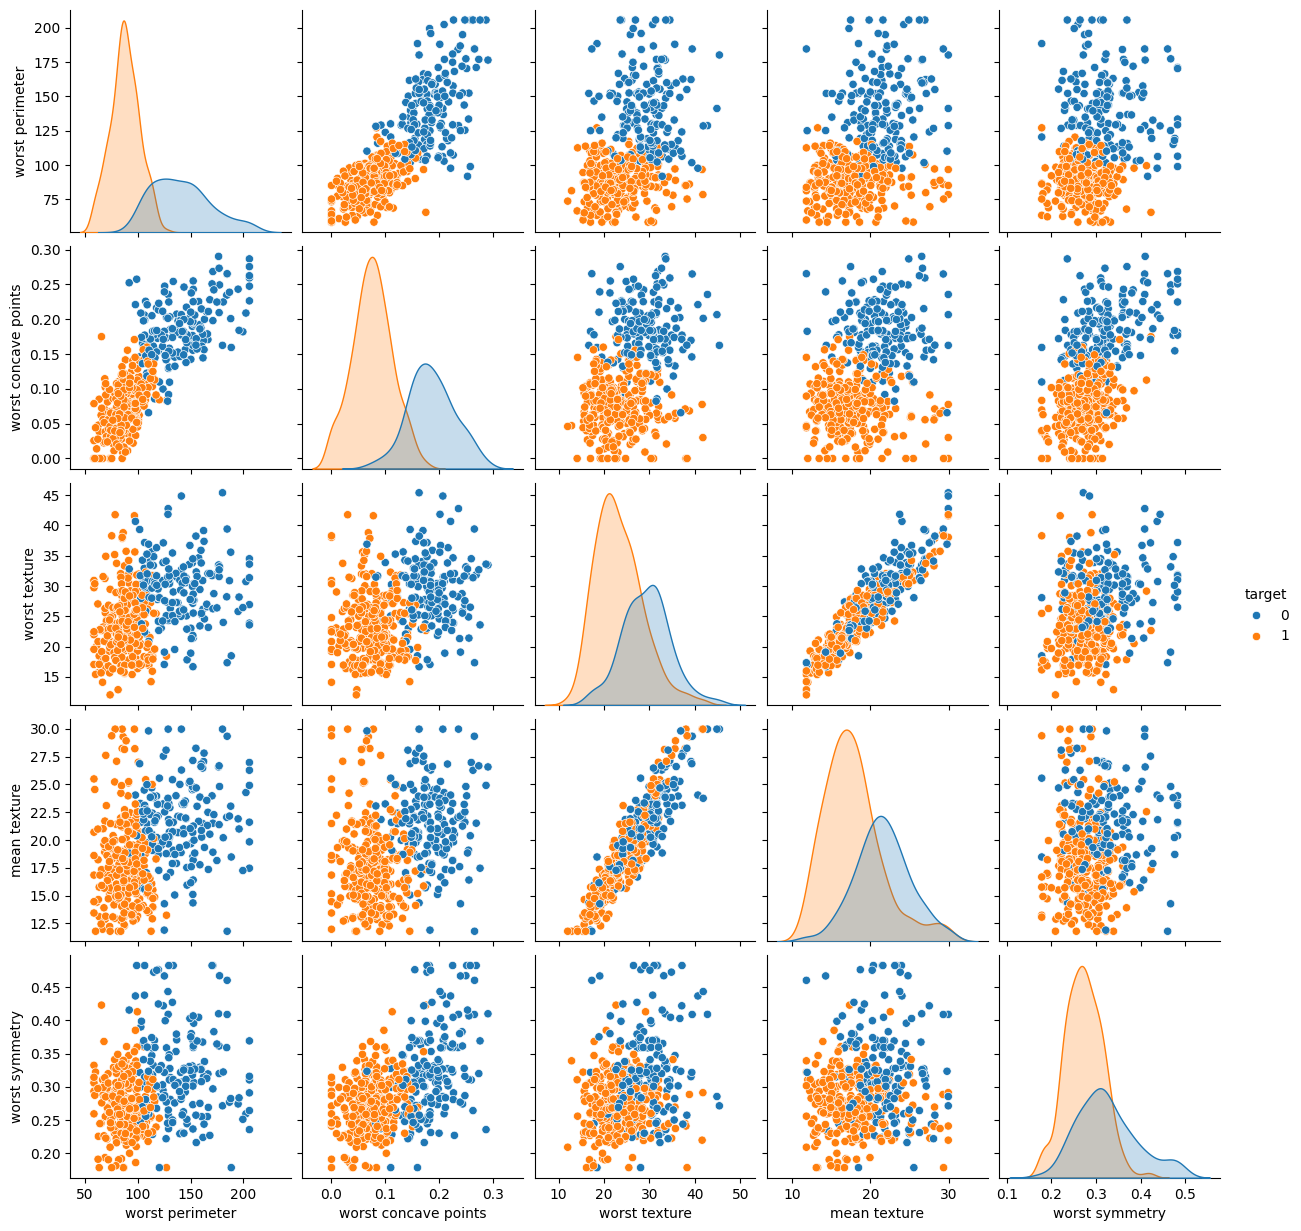

In [22]:
# Correlation between the 5 final variables we use for the models
data = df_train_mdl2[features_low_corr + [TARGET_LABEL]]
sns.pairplot(data=data, hue=TARGET_LABEL, diag_kind='kde')
plt.show()

In [23]:
df_train_mdl2.to_csv("data_treatment_train_55.csv", index=False)
df_val_mdl2.to_csv("data_treatment_val_55.csv", index=False)
df_test_mdl2.to_csv("data_treatment_test_55.csv", index=False)
df_test_bal_mdl2.to_csv("data_treatment_bal_test_55.csv", index=False)

# 4. Set up X and Y for first logistic regression model

In [24]:
features = [x for x in df_train_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_train, y_train = df_train_mdl2[features].copy(), df_train_mdl2[TARGET_LABEL].copy()
def_rate_train = y_train.mean()
print(f"x_train.shape={x_train.shape}, def_rate_train={def_rate_train}")

features = [x for x in df_val_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_val, y_val = df_val_mdl2[features].copy(), df_val_mdl2[TARGET_LABEL].copy()
def_rate_val = y_val.mean()
print(f"x_val.shape={x_val.shape}, def_rate_val={def_rate_val}")

features = [x for x in df_test_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_test, y_test = df_test_mdl2[features].copy(), df_test_mdl2[TARGET_LABEL].copy()
def_rate_test = y_test.mean()
print(f"x_test.shape={x_test.shape}, def_rate_test={def_rate_test}")

features = [x for x in df_test_bal_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_test_bal, y_test_bal = df_test_bal_mdl2[features].copy(), df_test_bal_mdl2[TARGET_LABEL].copy()
def_rate_test = y_test_bal.mean()
print(f"x_test.shape={x_test_bal.shape}, def_rate_test={def_rate_test}")

x_train.shape=(455, 5), def_rate_train=0.6263736263736264
x_val.shape=(57, 5), def_rate_val=0.631578947368421
x_test.shape=(57, 5), def_rate_test=0.631578947368421
x_test.shape=(28, 5), def_rate_test=0.25


# 5. Build and evaluate a logistic regression model

## 5.1 Stepwise for variable selection

In [25]:
# Function to evaluate logistic regression model and return AUROC score and recall
def evaluate_logistic_regression(x_train, y_train, x_test, y_test):
    model = LogisticRegression(random_state=RANDOM_STATE).fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_proba)
    y_pred = model.predict(x_test)
    recall = recall_score(y_test, y_pred)
    return auroc, recall

# Function to perform stepwise feature selection
def stepwise_feature_selection(x_train, y_train, x_val, y_val, min_features, max_features):
    best_features = None
    best_auroc = float('-inf')
    best_recall = 0

    for k in range(min_features, min(max_features + 1, len(x_train.columns) + 1)):
        for subset in combinations(x_train.columns, k):
            subset = list(subset)
            auroc, recall = evaluate_logistic_regression(x_train[subset], y_train, x_val[subset], y_val)
            if recall > best_recall and best_auroc - auroc < 0.01:
                best_auroc = auroc
                best_recall = recall
                best_features = subset

    return best_features, best_auroc, best_recall

# Perform stepwise feature selection with a minimum of 5 features and a maximum of 10 features
selected_features, best_auroc, best_recall = stepwise_feature_selection(x_train, y_train, x_val, y_val, min_features=3, max_features=5)

# Fit logistic regression with selected features
mdl_logistic_regression = LogisticRegression(random_state=RANDOM_STATE).fit(x_train[selected_features], y_train)

# Predict probabilities
y_train_prob = mdl_logistic_regression.predict_proba(x_train[selected_features])[:, 1]
y_val_prob = mdl_logistic_regression.predict_proba(x_val[selected_features])[:, 1]

# Compute AUROC
auroc_train = roc_auc_score(y_train, y_train_prob)
auroc_val = roc_auc_score(y_val, y_val_prob)

# Compute recall
recall_train = recall_score(y_train, mdl_logistic_regression.predict(x_train[selected_features]))
recall_val = recall_score(y_val, mdl_logistic_regression.predict(x_val[selected_features]))

# Print or analyze the metrics as desired
print("Selected Features:", selected_features)
print("AUROC on training set:", auroc_train)
print("AUROC on validation set:", auroc_val)
print("Recall on training set:", recall_train)
print("Recall on validation set:", recall_val)

Selected Features: ['worst perimeter', 'worst concave points', 'worst symmetry']
AUROC on training set: 0.9822703818369454
AUROC on validation set: 0.9457671957671958
Recall on training set: 0.9438596491228071
Recall on validation set: 0.9722222222222222


We now compare the results for our two best logistic regression models.

In [26]:
df_train_mdl3 = deepcopy(df_train_mdl2)
df_val_mdl3 = deepcopy(df_val_mdl2)
df_test_mdl3 = deepcopy(df_test_mdl2)
df_test_bal_mdl3 = deepcopy(df_test_bal_mdl2)

df_train_mdl3 = df_train_mdl3.drop(columns=['mean texture','worst texture'])
df_val_mdl3 = df_val_mdl3.drop(columns=['mean texture','worst texture'])
df_test_mdl3 = df_test_mdl3.drop(columns=['mean texture','worst texture'])
df_test_bal_mdl3 = df_test_bal_mdl3.drop(columns=['mean texture','worst texture'])

## 5.2 Logistic regression with 3 variables

In [27]:
features = [x for x in df_train_mdl3 if x not in ID_LABELS+[TARGET_LABEL]]
x_train3, y_train3 = df_train_mdl3[features].copy(), df_train_mdl3[TARGET_LABEL].copy()
def_rate_train = y_train3.mean()
print(f"x_train.shape={x_train.shape}, def_rate_train={def_rate_train}")

features = [x for x in df_val_mdl3 if x not in ID_LABELS+[TARGET_LABEL]]
x_val3, y_val3 = df_val_mdl3[features].copy(), df_val_mdl3[TARGET_LABEL].copy()
def_rate_val = y_val3.mean()
print(f"x_val.shape={x_val.shape}, def_rate_val={def_rate_val}")

features = [x for x in df_test_mdl3 if x not in ID_LABELS+[TARGET_LABEL]]
x_test3, y_test3 = df_test_mdl3[features].copy(), df_test_mdl3[TARGET_LABEL].copy()
def_rate_test = y_test3.mean()
print(f"x_test.shape={x_test3.shape}, def_rate_test={def_rate_test}")

features = [x for x in df_test_bal_mdl3 if x not in ID_LABELS+[TARGET_LABEL]]
x_test_bal3, y_test_bal3 = df_test_bal_mdl3[features].copy(), df_test_bal_mdl3[TARGET_LABEL].copy()
def_rate_test = y_test_bal3.mean()
print(f"x_test.shape={x_test_bal3.shape}, def_rate_test={def_rate_test}")

x_train.shape=(455, 5), def_rate_train=0.6263736263736264
x_val.shape=(57, 5), def_rate_val=0.631578947368421
x_test.shape=(57, 3), def_rate_test=0.631578947368421
x_test.shape=(28, 3), def_rate_test=0.25


### **Adjust the hyperparameters**

In [28]:
mdl_logistic_regression = LogisticRegression(random_state=RANDOM_STATE)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2']  # Regularization penalty
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(mdl_logistic_regression, param_grid, cv=5, scoring='recall')
grid_search.fit(x_train3, y_train3)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_C = list(best_params.values())[0]
best_penalty = list(best_params.values())[1]

Best Hyperparameters: {'C': 100, 'penalty': 'l2'}


In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
mdl_logistic_regression3 = LogisticRegression(random_state=RANDOM_STATE, C = best_C, penalty = best_penalty).fit(x_train3, y_train3)

y_hat_train = mdl_logistic_regression3.predict_proba(x_train3)[:, 1]
y_hat_val = mdl_logistic_regression3.predict_proba(x_val3)[:, 1]
y_hat_test = mdl_logistic_regression3.predict_proba(x_test3)[:, 1]

### **Risk ranking metrics**

In [30]:
# Compute average predicted probabilities
avg_pd_train, avg_pd_val, avg_pd_test = y_hat_train.mean(), y_hat_val.mean(), y_hat_test.mean()
auroc_train = roc_auc_score(y_true=y_train3, y_score=y_hat_train)
auroc_val = roc_auc_score(y_true=y_val3, y_score=y_hat_val)
auroc_test = roc_auc_score(y_true=y_test3, y_score=y_hat_test)

# Compute KS statistic
ks_statistic_train, _ = ks_2samp(y_hat_train[y_train3 == 1], y_hat_train[y_train3 == 0])
ks_statistic_val, _ = ks_2samp(y_hat_val[y_val3 == 1], y_hat_val[y_val3 == 0])
ks_statistic_test, _ = ks_2samp(y_hat_test[y_test3 == 1], y_hat_test[y_test3 == 0])

# Compute AIC
n_params = len(mdl_logistic_regression3.coef_[0]) + 1  # Number of parameters including intercept
log_likelihood_train = mdl_logistic_regression3.score(x_train3, y_train3)
log_likelihood_val = mdl_logistic_regression3.score(x_val3, y_val3)
log_likelihood_test = mdl_logistic_regression3.score(x_test3, y_test3)
aic_train = -2 * log_likelihood_train + 2 * n_params
aic_val = -2 * log_likelihood_val + 2 * n_params
aic_test = -2 * log_likelihood_test + 2 * n_params

data = [
    ["Train", def_rate_train, avg_pd_train, auroc_train, ks_statistic_train, aic_train],
    ["Validation", def_rate_val, avg_pd_val, auroc_val, ks_statistic_val, aic_val],
    ["Test", def_rate_test, avg_pd_test, auroc_test, ks_statistic_test, aic_test]
]

headers = ["Dataset", "Default Rate", "Average PD", "AUROC", "Kolmogorov S", "AIC"]
df = pd.DataFrame(data, columns=headers)
display(df)
#print(tabulate(data, headers=headers))

conditions_satisfied = False
target_pd_diff = abs(def_rate_val-avg_pd_val)
auroc_train_val_diff = abs(auroc_val-auroc_train)
if (auroc_val >= MIN_AUROC_VAL) & \
   (target_pd_diff < MAX_TARGET_PD_DIFF) & \
   (auroc_train_val_diff < MAX_AUROC_TRAIN_VAL_DIFF):
    conditions_satisfied = True

if conditions_satisfied:
    print(f"Found model that satisfies minimum requirements.")

else:
    print(f"Haven't found a model that statisfies minimum requirements.")

,Dataset,Default Rate,Average PD,AUROC,Kolmogorov S,AIC
0,Train,0.626374,0.626373,0.993519,0.907121,6.109890
1,Validation,0.631579,0.670673,0.932540,0.857143,6.140351
2,Test,0.250000,0.679884,0.986772,0.952381,6.105263


Found model that satisfies minimum requirements.


### **ROC Curve**

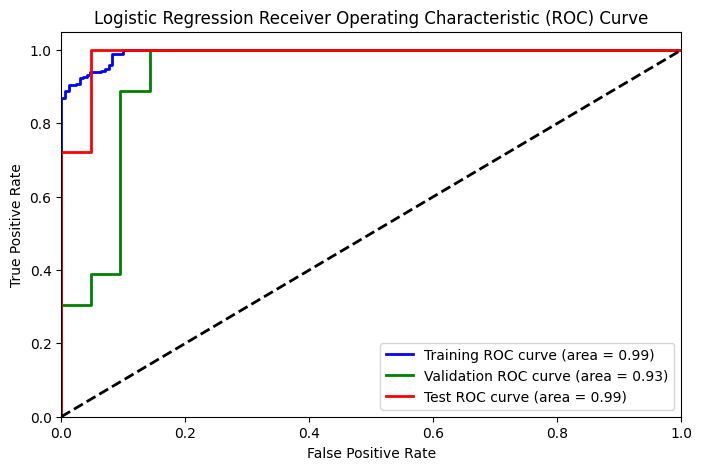

In [31]:
# Compute ROC curve and ROC area for each dataset
fpr_train, tpr_train, _ = roc_curve(y_train3, y_hat_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val3, y_hat_val)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test3, y_hat_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### **Precision-type metrics**

In [32]:
threshold = 0.5 #Also for precision metric calculations in the following models

#Training
y_hat_train_prob = np.where(y_hat_train >= threshold, 1, 0)
accuracy_train = accuracy_score(y_train3.values, y_hat_train_prob)
precision_train = precision_score(y_train3.values, y_hat_train_prob)
recall_train = recall_score(y_train3.values, y_hat_train_prob)
f1_train = f1_score(y_train3.values, y_hat_train_prob)

#Validation
y_hat_val_prob = np.where(y_hat_val >= threshold, 1, 0)
accuracy_val = accuracy_score(y_val3.values, y_hat_val_prob)
precision_val = precision_score(y_val3.values, y_hat_val_prob)
recall_val = recall_score(y_val3.values, y_hat_val_prob)
f1_val = f1_score(y_val3.values, y_hat_val_prob)

#Test
y_hat_test_prob = np.where(y_hat_test >= threshold, 1, 0)
accuracy_test = accuracy_score(y_test3.values, y_hat_test_prob)
precision_test = precision_score(y_test3.values, y_hat_test_prob)
recall_test = recall_score(y_test3.values, y_hat_test_prob)
f1_test = f1_score(y_test3.values, y_hat_test_prob)

metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1-score': [f1_train, f1_val, f1_test]
})

display(metrics_df)

,Dataset,Accuracy,Precision,Recall,F1-score
0,Training,0.945055,0.954545,0.957895,0.956217
1,Validation,0.929825,0.921053,0.972222,0.945946
2,Test,0.947368,0.923077,1.000000,0.960000


### **Confusion matrix**

In [33]:
datasets = ['Training', 'Validation', 'Test']
y_hats = [y_hat_train_prob, y_hat_val_prob, y_hat_test_prob]
y_trues = [y_train3, y_val3, y_test3]

training_cm = []
validation_cm = []
testing_cm = []

# Compute and store confusion matrices for each dataset
for dataset, y_true, y_hat in zip(datasets, y_trues, y_hats):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, np.where(y_hat >= threshold, 1, 0))
    
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    
    # Append to the corresponding list based on dataset type
    if dataset == 'Training':
        training_cm.append(cm_df)
    elif dataset == 'Validation':
        validation_cm.append(cm_df)
    elif dataset == 'Test':
        testing_cm.append(cm_df)

# Concatenate the confusion matrices horizontally for each dataset type
df_training_cm = pd.concat(training_cm, axis=1)
df_validation_cm = pd.concat(validation_cm, axis=1)
df_testing_cm = pd.concat(testing_cm, axis=1)

# Concatenate the confusion matrices vertically for each dataset type
df_combined_cm = pd.concat([df_training_cm, df_validation_cm, df_testing_cm], axis=0, keys=['Training', 'Validation', 'Testing'])
display(df_combined_cm)

Predicted Negative  Predicted Positive
Training   Actual Negative                 157                  13
           Actual Positive                  12                 273
Validation Actual Negative                  18                   3
           Actual Positive                   1                  35
Testing    Actual Negative                  18                   3
           Actual Positive                   0                  36

### **Precion-recall curve**

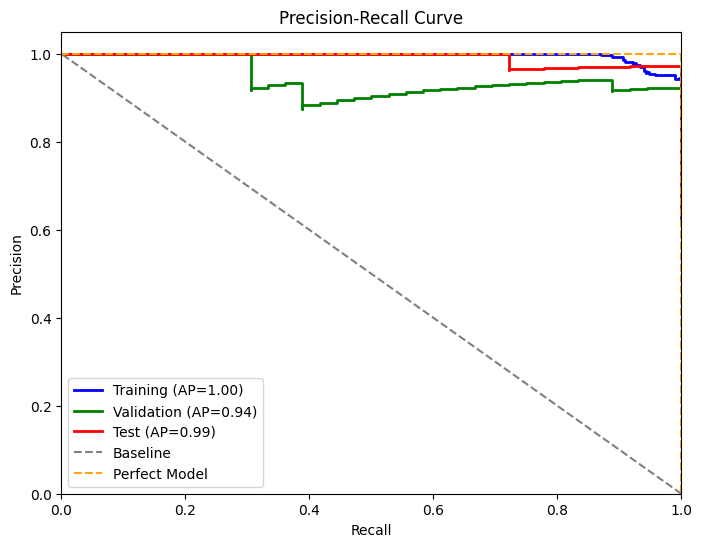

In [34]:
#Compute precision and recall for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train3, y_hat_train)
average_precision_train = average_precision_score(y_train3, y_hat_train)

# Compute precision and recall for the validation set
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val3, y_hat_val)
average_precision_val = average_precision_score(y_val3, y_hat_val)

# Compute precision and recall for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test3, y_hat_test)
average_precision_test = average_precision_score(y_test3, y_hat_test)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall_train, precision_train, color='b', lw = 2, where='post', label=f'Training (AP={average_precision_train:.2f})')
plt.step(recall_val, precision_val, color='g', lw=2, where='post', label=f'Validation (AP={average_precision_val:.2f})')
plt.step(recall_test, precision_test, color='r', lw=2, where='post', label=f'Test (AP={average_precision_test:.2f})')

# Add diagonal line (random classifier)
plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label = 'Baseline')

# Add curve representing a perfect model
plt.plot([0, 1], [1, 1], color='orange', linestyle='--', label = 'Perfect Model')
plt.plot([1, 1], [1, 0], color='orange', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### **SHAP value**

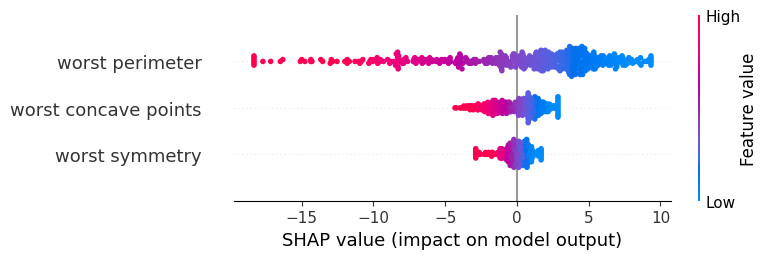

In [35]:
explainer_lr = shap.LinearExplainer(mdl_logistic_regression3,x_train3)
shap_lr = explainer_lr.shap_values(x_train3)
shap.summary_plot(shap_lr, x_train3)

### **Sensitiviy test**

All features show statistical significance to the predicition of model output

In [36]:
# Add an intercept term to the model
x_train_with_intercept = sm.add_constant(x_train3)

# Fit the logistic regression model
logit_model = sm.Logit(y_train3, x_train_with_intercept)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.096985
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      451
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Feb 2024   Pseudo R-squ.:                  0.8532
Time:                        11:27:11   Log-Likelihood:                -44.128
converged:                       True   LL-Null:                       -300.69
Covariance Type:            nonrobust   LLR p-value:                6.831e-111
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   32.1617      5.292      6.077      0.000      21.789      42.53

## 5.3 Logistic regression with 5 variables

In [37]:
features = [x for x in df_train_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_train, y_train = df_train_mdl2[features].copy(), df_train_mdl2[TARGET_LABEL].copy()
def_rate_train = y_train.mean()
print(f"x_train.shape={x_train.shape}, def_rate_train={def_rate_train}")

features = [x for x in df_val_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_val, y_val = df_val_mdl2[features].copy(), df_val_mdl2[TARGET_LABEL].copy()
def_rate_val = y_val.mean()
print(f"x_val.shape={x_val.shape}, def_rate_val={def_rate_val}")

features = [x for x in df_test_mdl2 if x not in ID_LABELS+[TARGET_LABEL]]
x_test, y_test = df_test_mdl2[features].copy(), df_test_mdl2[TARGET_LABEL].copy()
def_rate_test = y_test.mean()
print(f"x_test.shape={x_test.shape}, def_rate_test={def_rate_test}")

x_train.shape=(455, 5), def_rate_train=0.6263736263736264
x_val.shape=(57, 5), def_rate_val=0.631578947368421
x_test.shape=(57, 5), def_rate_test=0.631578947368421


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
mdl_logistic_regression = LogisticRegression(random_state=RANDOM_STATE, C = best_C, penalty = best_penalty).fit(x_train, y_train)

y_hat_train = mdl_logistic_regression.predict_proba(x_train)[:, 1]
y_hat_val = mdl_logistic_regression.predict_proba(x_val)[:, 1]
y_hat_test = mdl_logistic_regression.predict_proba(x_test)[:, 1]


### **Risk ranking metrics**

In [39]:
# Compute average predicted probabilities
avg_pd_train, avg_pd_val, avg_pd_test = y_hat_train.mean(), y_hat_val.mean(), y_hat_test.mean()
auroc_train = roc_auc_score(y_true=y_train, y_score=y_hat_train)
auroc_val = roc_auc_score(y_true=y_val, y_score=y_hat_val)
auroc_test = roc_auc_score(y_true=y_test, y_score=y_hat_test)

# Compute KS statistic
ks_statistic_train, _ = ks_2samp(y_hat_train[y_train == 1], y_hat_train[y_train == 0])
ks_statistic_val, _ = ks_2samp(y_hat_val[y_val == 1], y_hat_val[y_val == 0])
ks_statistic_test, _ = ks_2samp(y_hat_test[y_test == 1], y_hat_test[y_test == 0])

# Compute AIC
n_params = len(mdl_logistic_regression.coef_[0]) + 1  # Number of parameters including intercept
log_likelihood_train = mdl_logistic_regression.score(x_train, y_train)
log_likelihood_val = mdl_logistic_regression.score(x_val, y_val)
log_likelihood_test = mdl_logistic_regression.score(x_test, y_test)
aic_train = -2 * log_likelihood_train + 2 * n_params
aic_val = -2 * log_likelihood_val + 2 * n_params
aic_test = -2 * log_likelihood_test + 2 * n_params

data = [
    ["Train", def_rate_train, avg_pd_train, auroc_train, ks_statistic_train, aic_train],
    ["Validation", def_rate_val, avg_pd_val, auroc_val, ks_statistic_val, aic_val],
    ["Test", def_rate_test, avg_pd_test, auroc_test, ks_statistic_test, aic_test]
]

headers = ["Dataset", "Default Rate", "Average PD", "AUROC", "Kolmogorov S", "AIC"]
df = pd.DataFrame(data, columns=headers)
display(df)
#print(tabulate(data, headers=headers))

conditions_satisfied = False
target_pd_diff = abs(def_rate_val-avg_pd_val)
auroc_train_val_diff = abs(auroc_val-auroc_train)
if (auroc_val >= MIN_AUROC_VAL) & \
   (target_pd_diff < MAX_TARGET_PD_DIFF) & \
   (auroc_train_val_diff < MAX_AUROC_TRAIN_VAL_DIFF):
    conditions_satisfied = True

if conditions_satisfied:
    print(f"Found model that satisfies minimum requirements.")

else:
    print(f"Haven't found a model that statisfies minimum requirements.")

,Dataset,Default Rate,Average PD,AUROC,Kolmogorov S,AIC
0,Train,0.626374,0.626373,0.997915,0.949536,10.048352
1,Validation,0.631579,0.658514,0.943122,0.821429,10.210526
2,Test,0.631579,0.678399,0.998677,0.972222,10.140351


Found model that satisfies minimum requirements.


### **ROC Curve**

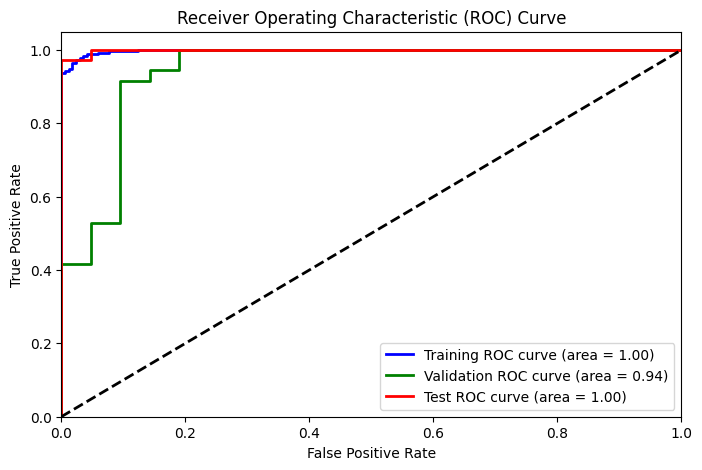

In [40]:
# Compute ROC curve and ROC area for each dataset
fpr_train, tpr_train, _ = roc_curve(y_train, y_hat_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_hat_val)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_hat_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### **Precision-type metrics**

In [41]:
#Training
y_hat_train_prob = np.where(y_hat_train >= threshold, 1, 0)
accuracy_train = accuracy_score(y_train.values, y_hat_train_prob)
precision_train = precision_score(y_train.values, y_hat_train_prob)
recall_train = recall_score(y_train.values, y_hat_train_prob)
f1_train = f1_score(y_train.values, y_hat_train_prob)

#Validation
y_hat_val_prob = np.where(y_hat_val >= threshold, 1, 0)
accuracy_val = accuracy_score(y_val.values, y_hat_val_prob)
precision_val = precision_score(y_val.values, y_hat_val_prob)
recall_val = recall_score(y_val.values, y_hat_val_prob)
f1_val = f1_score(y_val.values, y_hat_val_prob)

#Test
y_hat_test_prob = np.where(y_hat_test >= threshold, 1, 0)
accuracy_test = accuracy_score(y_test.values, y_hat_test_prob)
precision_test = precision_score(y_test.values, y_hat_test_prob)
recall_test = recall_score(y_test.values, y_hat_test_prob)
f1_test = f1_score(y_test.values, y_hat_test_prob)

metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1-score': [f1_train, f1_val, f1_test]
})

display(metrics_df)

,Dataset,Accuracy,Precision,Recall,F1-score
0,Training,0.975824,0.982394,0.978947,0.980668
1,Validation,0.894737,0.894737,0.944444,0.918919
2,Test,0.929825,0.900000,1.000000,0.947368


In [42]:
datasets = ['Training', 'Validation', 'Test']
y_hats = [y_hat_train_prob, y_hat_val_prob, y_hat_test_prob]
y_trues = [y_train, y_val, y_test]

training_cm = []
validation_cm = []
testing_cm = []

# Compute and store confusion matrices for each dataset
for dataset, y_true, y_hat in zip(datasets, y_trues, y_hats):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, np.where(y_hat >= threshold, 1, 0))
    
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    
    # Append to the corresponding list based on dataset type
    if dataset == 'Training':
        training_cm.append(cm_df)
    elif dataset == 'Validation':
        validation_cm.append(cm_df)
    elif dataset == 'Test':
        testing_cm.append(cm_df)

# Concatenate the confusion matrices horizontally for each dataset type
df_training_cm = pd.concat(training_cm, axis=1)
df_validation_cm = pd.concat(validation_cm, axis=1)
df_testing_cm = pd.concat(testing_cm, axis=1)

# Concatenate the confusion matrices vertically for each dataset type
df_combined_cm = pd.concat([df_training_cm, df_validation_cm, df_testing_cm], axis=0, keys=['Training', 'Validation', 'Testing'])
display(df_combined_cm)

Predicted Negative  Predicted Positive
Training   Actual Negative                 165                   5
           Actual Positive                   6                 279
Validation Actual Negative                  17                   4
           Actual Positive                   2                  34
Testing    Actual Negative                  17                   4
           Actual Positive                   0                  36

### **Precion-recall curve**

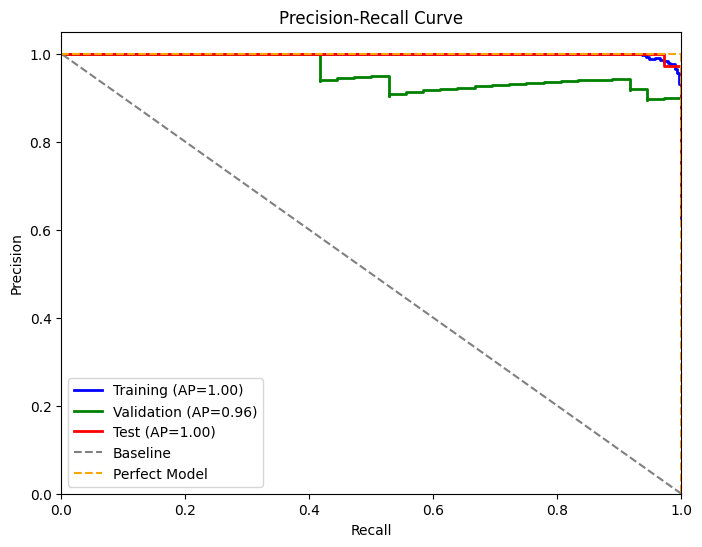

In [43]:
#Compute precision and recall for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_hat_train)
average_precision_train = average_precision_score(y_train, y_hat_train)

# Compute precision and recall for the validation set
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_hat_val)
average_precision_val = average_precision_score(y_val, y_hat_val)

# Compute precision and recall for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_hat_test)
average_precision_test = average_precision_score(y_test, y_hat_test)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall_train, precision_train, color='b', lw = 2, where='post', label=f'Training (AP={average_precision_train:.2f})')
plt.step(recall_val, precision_val, color='g', lw=2, where='post', label=f'Validation (AP={average_precision_val:.2f})')
plt.step(recall_test, precision_test, color='r', lw=2, where='post', label=f'Test (AP={average_precision_test:.2f})')

# Add diagonal line (random classifier)
plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label = 'Baseline')

# Add curve representing a perfect model
plt.plot([0, 1], [1, 1], color='orange', linestyle='--', label = 'Perfect Model')
plt.plot([1, 1], [1, 0], color='orange', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### **SHAP value**

According tom SHAP plot, "worst perimeter" contributes the most to impact of prediction on model output for Logistic Regression Model. Conversely, "mean texture" & "worst symmetry" seems to be the least. Therefore it seems we can just keep 3 features to see if there is an improvement on recall and AUROC

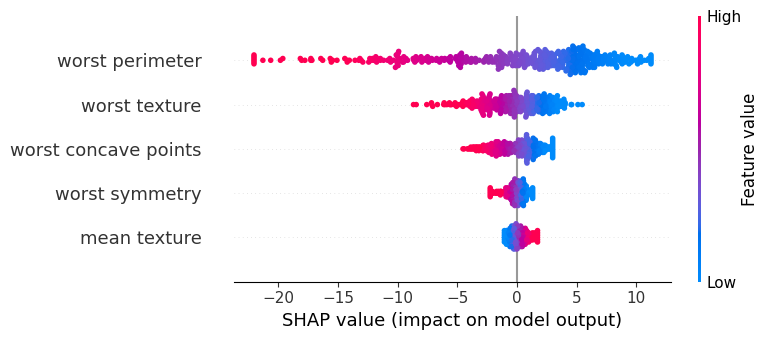

In [44]:
explainer_lr = shap.LinearExplainer(mdl_logistic_regression,x_train)
shap_lr = explainer_lr.shap_values(x_train)
shap.summary_plot(shap_lr, x_train)

### **Sensitiviy test**

For varibles with p-value < 0.05 (significance level), it indicates that there is a strong evidence to against the null hypothesis which means the variables are statistical significant.

For instnace, the coefficient for worst concave points is -40.33. A one-unit increase in worst concave points leads to a decrease in the log odds of testing positive for breast cancer by approximately 40.33 units. That relates with the correlogram where the orange or positive area is related with smaller values, so if the values decrease the possibility of testing positive increase.

In [45]:
# Add an intercept term to the model
x_train_with_intercept = sm.add_constant(x_train)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, x_train_with_intercept)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.050788
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      449
Method:                           MLE   Df Model:                            5
Date:                Fri, 16 Feb 2024   Pseudo R-squ.:                  0.9231
Time:                        11:27:14   Log-Likelihood:                -23.108
converged:                       True   LL-Null:                       -300.69
Covariance Type:            nonrobust   LLR p-value:                9.808e-118
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   52.8513     10.700      4.939      0.000      31.879      73.82

# 6. Build and evaluate XGBoost model

In [46]:
RANDOM_STATE = 42
mdl_xgboost_best = None
n_estimators_best = None
auroc_val_best = -float('inf')  # Initialize to a very small value
aic_val_best = float('inf')

conditions_satisfied_xgb = False

headers = ["n_estimators", "Default Rate", "Average PD", "AUROC", "Kolmogorov S", "AIC"]
results_table = []

for n_estimators in XGBOOST_N_ESTIMATORS:
    mdl_xgboost = xgb.XGBClassifier(random_state=RANDOM_STATE, 
                                    max_depth=XGBOOST_MAX_DEPTH,
                                    n_estimators=n_estimators).fit(x_train, y_train)

    y_hat_train = mdl_xgboost.predict_proba(x_train)[:, 1]
    y_hat_val = mdl_xgboost.predict_proba(x_val)[:, 1]
    y_hat_test = mdl_xgboost.predict_proba(x_test)[:, 1]
    
    avg_pd_train, avg_pd_val, avg_pd_test = y_hat_train.mean(), y_hat_val.mean(), y_hat_test.mean()
    auroc_train = roc_auc_score(y_true=y_train, y_score=y_hat_train)
    auroc_val = roc_auc_score(y_true=y_val, y_score=y_hat_val)
    auroc_test = roc_auc_score(y_true=y_test, y_score=y_hat_test)
    
    target_pd_diff = abs(def_rate_val-avg_pd_val)
    auroc_train_val_diff = abs(auroc_val-auroc_train)
    
    ks_statistic_train, _ = ks_2samp(y_hat_train[y_train == 1], y_hat_train[y_train == 0])
    ks_statistic_val, _ = ks_2samp(y_hat_val[y_val == 1], y_hat_val[y_val == 0])
    ks_statistic_test, _ = ks_2samp(y_hat_test[y_test == 1], y_hat_test[y_test == 0])
    
    n_params = len(mdl_xgboost.feature_importances_) + 1  # Number of parameters including intercept
    log_likelihood_train = mdl_xgboost.score(x_train, y_train)
    log_likelihood_val = mdl_xgboost.score(x_val, y_val)
    log_likelihood_test = mdl_xgboost.score(x_test, y_test)
    aic_train = -2 * log_likelihood_train + 2 * n_params
    aic_val = -2 * log_likelihood_val + 2 * n_params
    aic_test = -2 * log_likelihood_test + 2 * n_params
    
    results_row = [n_estimators, def_rate_val, avg_pd_val, auroc_val, ks_statistic_val, aic_val]
    print(f"\nResults for n_estimators={n_estimators}:")
    print(tabulate([results_row], headers=headers))

    if (auroc_val >= MIN_AUROC_VAL) & \
       (target_pd_diff < MAX_TARGET_PD_DIFF) & \
       (auroc_train_val_diff < MAX_AUROC_TRAIN_VAL_DIFF):
        conditions_satisfied_xgb = True

        if auroc_val > auroc_val_best:
            mdl_xgboost_best = deepcopy(mdl_xgboost)
            n_estimators_best = n_estimators
            auroc_val_best = auroc_val
            aic_val_best = aic_val
            
        
if conditions_satisfied_xgb:
    print(f"\nFound model that satisfies minimum requirements.")
    print(f"Best model has n_estimators={n_estimators_best}")
else:
    print(f"\nHaven't found a model that satisfies minimum requirements.")


Results for n_estimators=50:
  n_estimators    Default Rate    Average PD     AUROC    Kolmogorov S      AIC
--------------  --------------  ------------  --------  --------------  -------
            50        0.631579       0.65992  0.931217        0.849206  10.2105

Results for n_estimators=100:
  n_estimators    Default Rate    Average PD     AUROC    Kolmogorov S      AIC
--------------  --------------  ------------  --------  --------------  -------
           100        0.631579      0.658701  0.929894        0.849206  10.2105

Results for n_estimators=200:
  n_estimators    Default Rate    Average PD     AUROC    Kolmogorov S      AIC
--------------  --------------  ------------  --------  --------------  -------
           200        0.631579      0.659664  0.929894        0.849206  10.1754

Found model that satisfies minimum requirements.
Best model has n_estimators=50


## Precision-type Metrics

In [47]:
# Assume mdl_xgboost_best is the best XGBoost model obtained
y_hat_train = mdl_xgboost_best.predict_proba(x_train)[:, 1]
y_hat_val = mdl_xgboost_best.predict_proba(x_val)[:, 1]
y_hat_test = mdl_xgboost_best.predict_proba(x_test)[:, 1]

#Training
y_hat_train_prob = np.where(y_hat_train >= threshold, 1, 0)
accuracy_train = accuracy_score(y_train.values, y_hat_train_prob)
precision_train = precision_score(y_train.values, y_hat_train_prob)
recall_train = recall_score(y_train.values, y_hat_train_prob)
f1_train = f1_score(y_train.values, y_hat_train_prob)

#Validation
y_hat_val_prob = np.where(y_hat_val >= threshold, 1, 0)
accuracy_val = accuracy_score(y_val.values, y_hat_val_prob)
precision_val = precision_score(y_val.values, y_hat_val_prob)
recall_val = recall_score(y_val.values, y_hat_val_prob)
f1_val = f1_score(y_val.values, y_hat_val_prob)

#Test
y_hat_test_prob = np.where(y_hat_test >= threshold, 1, 0)
accuracy_test = accuracy_score(y_test.values, y_hat_test_prob)
precision_test = precision_score(y_test.values, y_hat_test_prob)
recall_test = recall_score(y_test.values, y_hat_test_prob)
f1_test = f1_score(y_test.values, y_hat_test_prob)

metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1-score': [f1_train, f1_val, f1_test]
})

display(metrics_df)

,Dataset,Accuracy,Precision,Recall,F1-score
0,Training,1.000000,1.000000,1.000000,1.000000
1,Validation,0.894737,0.894737,0.944444,0.918919
2,Test,0.947368,0.923077,1.000000,0.960000


## Confusion Matrix

In [48]:
# Set the threshold for classification
threshold_xgb = 0.5

datasets_xgb = ['Training', 'Validation', 'Test']
y_hats_xgb = [y_hat_train, y_hat_val, y_hat_test]
y_trues_xgb = [y_train, y_val, y_test]

training_cm_xgb = []
validation_cm_xgb = []
testing_cm_xgb = []

# Compute and store confusion matrices for each dataset
for dataset, y_true, y_hat in zip(datasets_xgb, y_trues_xgb, y_hats_xgb):
    # Compute confusion matrix
    cm_xgb = confusion_matrix(y_true, np.where(y_hat >= threshold_xgb, 1, 0))
    
    # Create DataFrame for confusion matrix
    cm_df_xgb = pd.DataFrame(cm_xgb, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    
    # Append to the corresponding list based on dataset type
    if dataset == 'Training':
        training_cm_xgb.append(cm_df_xgb)
    elif dataset == 'Validation':
        validation_cm_xgb.append(cm_df_xgb)
    elif dataset == 'Test':
        testing_cm_xgb.append(cm_df_xgb)

# Concatenate the confusion matrices horizontally for each dataset type
df_training_cm_xgb = pd.concat(training_cm_xgb, axis=1)
df_validation_cm_xgb = pd.concat(validation_cm_xgb, axis=1)
df_testing_cm_xgb = pd.concat(testing_cm_xgb, axis=1)

# Concatenate the confusion matrices vertically for each dataset type
df_combined_cm_xgb = pd.concat([df_training_cm_xgb, df_validation_cm_xgb, df_testing_cm_xgb], axis=0, keys=['Training', 'Validation', 'Testing'])
display(df_combined_cm_xgb)

Predicted Negative  Predicted Positive
Training   Actual Negative                 170                   0
           Actual Positive                   0                 285
Validation Actual Negative                  17                   4
           Actual Positive                   2                  34
Testing    Actual Negative                  18                   3
           Actual Positive                   0                  36

## Precision-recall curve

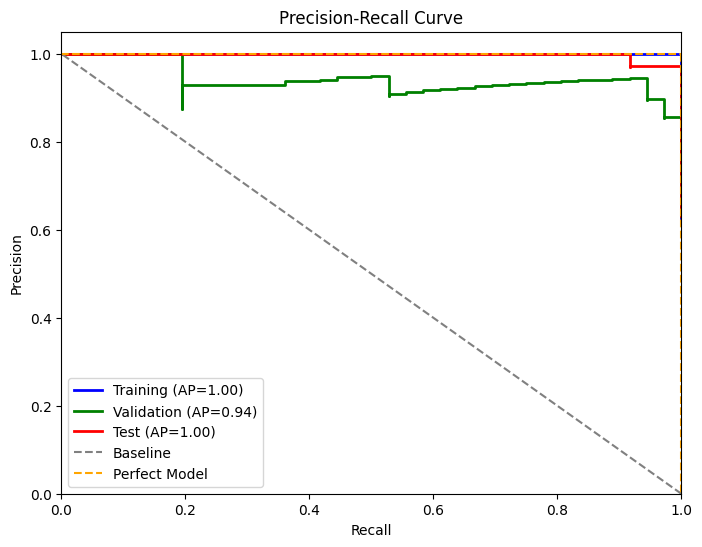

In [49]:
#Compute precision and recall for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_hat_train)
average_precision_train = average_precision_score(y_train, y_hat_train)

# Compute precision and recall for the validation set
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_hat_val)
average_precision_val = average_precision_score(y_val, y_hat_val)

# Compute precision and recall for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_hat_test)
average_precision_test = average_precision_score(y_test, y_hat_test)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall_train, precision_train, color='b', lw = 2, where='post', label=f'Training (AP={average_precision_train:.2f})')
plt.step(recall_val, precision_val, color='g', lw=2, where='post', label=f'Validation (AP={average_precision_val:.2f})')
plt.step(recall_test, precision_test, color='r', lw=2, where='post', label=f'Test (AP={average_precision_test:.2f})')

# Add diagonal line (random classifier)
plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label = 'Baseline')

# Add curve representing a perfect model
plt.plot([0, 1], [1, 1], color='orange', linestyle='--', label = 'Perfect Model')
plt.plot([1, 1], [1, 0], color='orange', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## SHAP Plot

Spread on each feature is closer to each other than previous model, indicating that all 5 features show some significant impact.

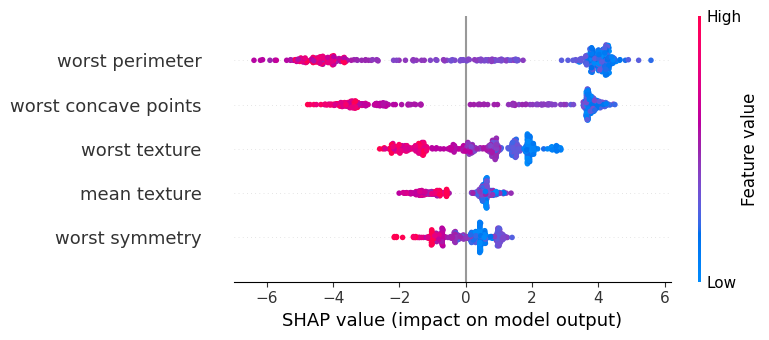

In [50]:
explainer_xgb = shap.TreeExplainer(mdl_xgboost)
shap_xgb = explainer_xgb.shap_values(x_train)
shap.summary_plot(shap_xgb, x_train)

## ROC, AUROC

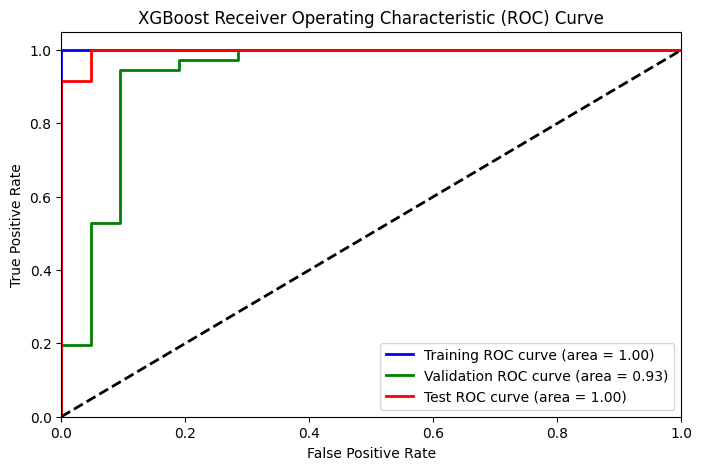

In [51]:
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_hat_train)
roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)

fpr_val_xgb, tpr_val_xgb, _ = roc_curve(y_val, y_hat_val)
roc_auc_val_xgb = auc(fpr_val_xgb, tpr_val_xgb)

fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_hat_test)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

# Plot ROC curve for XGBoost
plt.figure(figsize=(8, 5))
plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train_xgb:.2f})')
plt.plot(fpr_val_xgb, tpr_val_xgb, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_xgb:.2f})')
plt.plot(fpr_test_xgb, tpr_test_xgb, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# 7. Build and Evaluate Random Forest Model

In [52]:
headers = ["n_estimators", "AUROC (Validation)", "Target PD Difference", "AUROC Train-Val Difference", "AIC (Validation)"]

mdl_rf_best = None
n_estimators_best = None
auroc_val_best = -float('inf')  # Initialize to a very small value
aic_val_best = float('inf')

conditions_satisfied_rf = False

for n_estimators in RF_N_ESTIMATORS:
    mdl_rf = RandomForestClassifier(random_state=RANDOM_STATE,
                                    n_estimators=n_estimators).fit(x_train, y_train)

    y_hat_train = mdl_rf.predict_proba(x_train)[:, 1]
    y_hat_val = mdl_rf.predict_proba(x_val)[:, 1]
    y_hat_test = mdl_rf.predict_proba(x_test)[:, 1]

    avg_pd_train, avg_pd_val, avg_pd_test = y_hat_train.mean(), y_hat_val.mean(), y_hat_test.mean()
    auroc_train = roc_auc_score(y_true=y_train, y_score=y_hat_train)
    auroc_val = roc_auc_score(y_true=y_val, y_score=y_hat_val)
    auroc_test = roc_auc_score(y_true=y_test, y_score=y_hat_test)

    ks_statistic_train, _ = ks_2samp(y_hat_train[y_train == 1], y_hat_train[y_train == 0])
    ks_statistic_val, _ = ks_2samp(y_hat_val[y_val == 1], y_hat_val[y_val == 0])
    ks_statistic_test, _ = ks_2samp(y_hat_test[y_test == 1], y_hat_test[y_test == 0])

    target_pd_diff = abs(def_rate_val - avg_pd_val)
    auroc_train_val_diff = abs(auroc_val - auroc_train)

    # Calculate AIC
    n_params = len(mdl_rf.feature_importances_) + 1  # Number of parameters including intercept
    log_likelihood_train = mdl_rf.score(x_train, y_train)
    log_likelihood_val = mdl_rf.score(x_val, y_val)
    log_likelihood_test = mdl_rf.score(x_test, y_test)
    aic_train = -2 * log_likelihood_train + 2 * n_params
    aic_val = -2 * log_likelihood_val + 2 * n_params
    aic_test = -2 * log_likelihood_test + 2 * n_params

    results_row = [n_estimators, auroc_val, target_pd_diff, auroc_train_val_diff, aic_val]
    print(f"\nResults for n_estimators={n_estimators}:")
    print(tabulate([results_row], headers=headers))

    if (auroc_val >= MIN_AUROC_VAL) & \
       (target_pd_diff < MAX_TARGET_PD_DIFF) & \
       (auroc_train_val_diff < MAX_AUROC_TRAIN_VAL_DIFF):
        conditions_satisfied_rf = True

        if auroc_val > auroc_val_best:
            mdl_rf_best = deepcopy(mdl_rf)
            n_estimators_best = n_estimators
            auroc_val_best = auroc_val
            aic_val_best = aic_val

# Print overall best model
if conditions_satisfied_rf:
    print(f"\nFound model that satisfies minimum requirements.")
    print(f"Best model has n_estimators={n_estimators_best}")
else:
    print(f"\nHaven't found a model that satisfies minimum requirements.")



Results for n_estimators=50:
  n_estimators    AUROC (Validation)    Target PD Difference    AUROC Train-Val Difference    AIC (Validation)
--------------  --------------------  ----------------------  ----------------------------  ------------------
            50              0.947751               0.0389474                     0.0522487             10.1754

Results for n_estimators=100:
  n_estimators    AUROC (Validation)    Target PD Difference    AUROC Train-Val Difference    AIC (Validation)
--------------  --------------------  ----------------------  ----------------------------  ------------------
           100              0.945767               0.0368421                     0.0542328             10.1754

Results for n_estimators=200:
  n_estimators    AUROC (Validation)    Target PD Difference    AUROC Train-Val Difference    AIC (Validation)
--------------  --------------------  ----------------------  ----------------------------  ------------------
           200      

## Precision-type Metrics

In [53]:
#Assumming the best model is: mdl_rf_best
y_hat_train = mdl_rf_best.predict_proba(x_train)[:, 1]
y_hat_val = mdl_rf_best.predict_proba(x_val)[:, 1]
y_hat_test = mdl_rf_best.predict_proba(x_test)[:, 1]

#Training
y_hat_train_prob = np.where(y_hat_train >= threshold, 1, 0)
accuracy_train = accuracy_score(y_train.values, y_hat_train_prob)
precision_train = precision_score(y_train.values, y_hat_train_prob)
recall_train = recall_score(y_train.values, y_hat_train_prob)
f1_train = f1_score(y_train.values, y_hat_train_prob)

#Validation
y_hat_val_prob = np.where(y_hat_val >= threshold, 1, 0)
accuracy_val = accuracy_score(y_val.values, y_hat_val_prob)
precision_val = precision_score(y_val.values, y_hat_val_prob)
recall_val = recall_score(y_val.values, y_hat_val_prob)
f1_val = f1_score(y_val.values, y_hat_val_prob)

#Test
y_hat_test_prob = np.where(y_hat_test >= threshold, 1, 0)
accuracy_test = accuracy_score(y_test.values, y_hat_test_prob)
precision_test = precision_score(y_test.values, y_hat_test_prob)
recall_test = recall_score(y_test.values, y_hat_test_prob)
f1_test = f1_score(y_test.values, y_hat_test_prob)

metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1-score': [f1_train, f1_val, f1_test]
})

display(metrics_df)

,Dataset,Accuracy,Precision,Recall,F1-score
0,Training,1.000000,1.000000,1.000000,1.000000
1,Validation,0.912281,0.897436,0.972222,0.933333
2,Test,0.964912,0.947368,1.000000,0.972973


## Confusion Matrix

In [54]:
threshold_rf = 0.5
datasets_rf = ['Training', 'Validation', 'Test']
y_hats_rf = [y_hat_train, y_hat_val, y_hat_test]
y_trues_rf = [y_train, y_val, y_test]

training_cm_rf = []
validation_cm_rf = []
testing_cm_rf = []

# Compute and store confusion matrices for each dataset
for dataset, y_true, y_hat in zip(datasets_rf, y_trues_rf, y_hats_rf):
    # Compute confusion matrix
    cm_rf = confusion_matrix(y_true, np.where(y_hat >= threshold_rf, 1, 0))
    
    # Create DataFrame for confusion matrix
    cm_df_rf = pd.DataFrame(cm_rf, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    
    # Append to the corresponding list based on dataset type
    if dataset == 'Training':
        training_cm_rf.append(cm_df_rf)
    elif dataset == 'Validation':
        validation_cm_rf.append(cm_df_rf)
    elif dataset == 'Test':
        testing_cm_rf.append(cm_df_rf)

# Concatenate the confusion matrices horizontally for each dataset type
df_training_cm_rf = pd.concat(training_cm_rf, axis=1)
df_validation_cm_rf = pd.concat(validation_cm_rf, axis=1)
df_testing_cm_rf = pd.concat(testing_cm_rf, axis=1)

# Concatenate the confusion matrices vertically for each dataset type
df_combined_cm_rf = pd.concat([df_training_cm_rf, df_validation_cm_rf, df_testing_cm_rf], axis=0, keys=['Training', 'Validation', 'Testing'])
display(df_combined_cm_rf)


Predicted Negative  Predicted Positive
Training   Actual Negative                 170                   0
           Actual Positive                   0                 285
Validation Actual Negative                  17                   4
           Actual Positive                   1                  35
Testing    Actual Negative                  19                   2
           Actual Positive                   0                  36

## Precision-recall curve

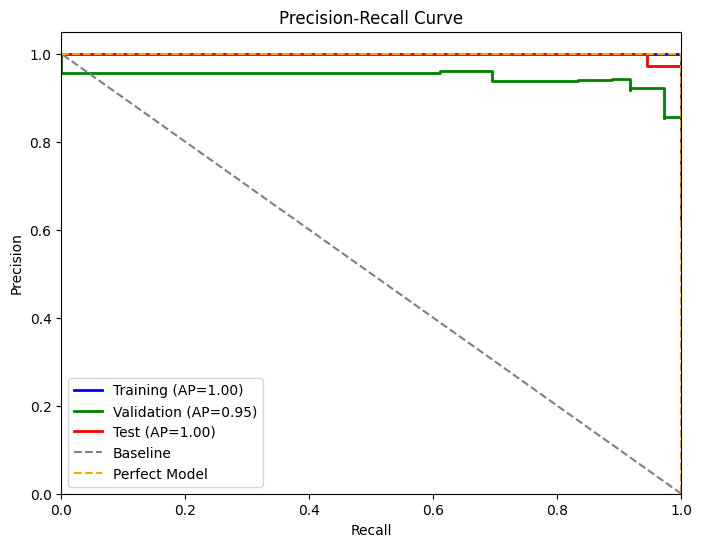

In [55]:
#Compute precision and recall for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_hat_train)
average_precision_train = average_precision_score(y_train, y_hat_train)

# Compute precision and recall for the validation set
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_hat_val)
average_precision_val = average_precision_score(y_val, y_hat_val)

# Compute precision and recall for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_hat_test)
average_precision_test = average_precision_score(y_test, y_hat_test)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall_train, precision_train, color='b', lw = 2, where='post', label=f'Training (AP={average_precision_train:.2f})')
plt.step(recall_val, precision_val, color='g', lw=2, where='post', label=f'Validation (AP={average_precision_val:.2f})')
plt.step(recall_test, precision_test, color='r', lw=2, where='post', label=f'Test (AP={average_precision_test:.2f})')

# Add diagonal line (random classifier)
plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label = 'Baseline')

# Add curve representing a perfect model
plt.plot([0, 1], [1, 1], color='orange', linestyle='--', label = 'Perfect Model')
plt.plot([1, 1], [1, 0], color='orange', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## SHAP Plot

“worst perimeter” & “worst concave point” contribute the most on prediction of the likelihood of class 0 (negative class) and class 1 (positive class).

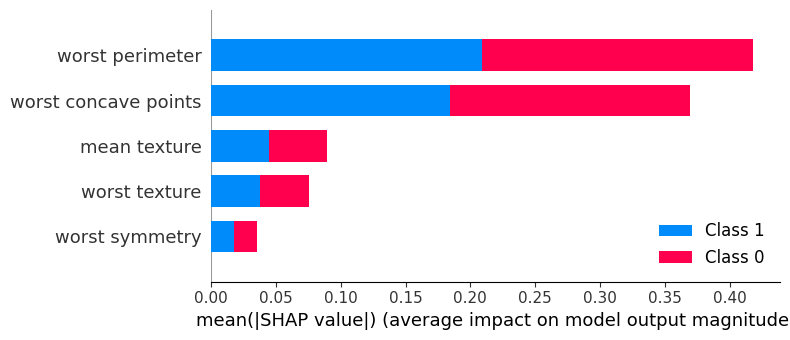

In [56]:
explainer_rf = shap.TreeExplainer(mdl_rf)
shap_rf = explainer_rf.shap_values(x_train)
shap.summary_plot(shap_rf, x_train)

## ROC, AUROC

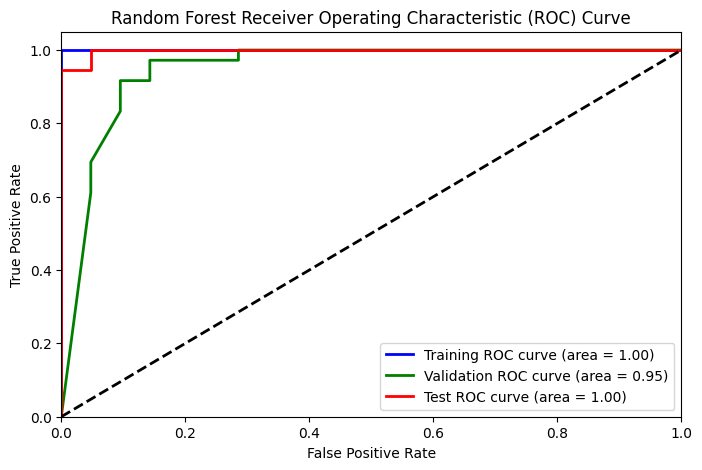

In [57]:
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_hat_train)
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

fpr_val_rf, tpr_val_rf, _ = roc_curve(y_val, y_hat_val)
roc_auc_val_rf = auc(fpr_val_rf, tpr_val_rf)

fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_hat_test)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 5))
plt.plot(fpr_train_rf, tpr_train_rf, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train_rf:.2f})')
plt.plot(fpr_val_rf, tpr_val_rf, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_rf:.2f})')
plt.plot(fpr_test_rf, tpr_test_rf, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test_rf:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


For all ROC Curves and Precision & Recall Curves of Logistic, Random Forest and XGBoost; they all show a perfect performance on either training or testing data. It suggests that our model has learned the underlying patterns in the data very well and is capable of making perfect predictions.

# 8. Model selection

In [58]:
models = {
    "Logistic Regression 3 variables": {
        "model": mdl_logistic_regression3,
        "x_train": x_train3,
        "x_val": x_val3,
        "x_test": x_test3,
        "y_train": y_train3,
        "y_val": y_val3,
        "y_test": y_test3
    },
    "Logistic Regression 5 variables": {
        "model": mdl_logistic_regression,
        "x_train": x_train,
        "x_val": x_val,
        "x_test": x_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    },
    "XGBoost": {
        "model": mdl_xgboost_best,
        "x_train": x_train,
        "x_val": x_val,
        "x_test": x_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    },
    "Random Forest": {
        "model": mdl_rf_best,
        "x_train": x_train,
        "x_val": x_val,
        "x_test": x_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }
}

results = {}

for model_name, model_data in models.items():
    model = model_data["model"]
    x_train_model = model_data["x_train"]
    x_val_model = model_data["x_val"]
    x_test_model = model_data["x_test"]
    y_train_model = model_data["y_train"]
    y_val_model = model_data["y_val"]
    y_test_model = model_data["y_test"]

    y_hat_train = model.predict_proba(x_train_model)[:, 1]
    y_hat_val = model.predict_proba(x_val_model)[:, 1]
    y_hat_test = model.predict_proba(x_test_model)[:, 1]

    # Calculate AUROC and KS for training set
    auroc_train = roc_auc_score(y_true=y_train_model, y_score=y_hat_train)
    ks_statistic_train, _ = ks_2samp(y_hat_train[y_train_model == 1], y_hat_train[y_train_model == 0])

    # Calculate AUROC and KS for validation set
    auroc_val = roc_auc_score(y_true=y_val_model, y_score=y_hat_val)
    ks_statistic_val, _ = ks_2samp(y_hat_val[y_val_model == 1], y_hat_val[y_val_model == 0])

    # Calculate AUROC and KS for test set
    auroc_test = roc_auc_score(y_true=y_test_model, y_score=y_hat_test)
    ks_statistic_test, _ = ks_2samp(y_hat_test[y_test_model == 1], y_hat_test[y_test_model == 0])

    # Update results dictionary
    results[model_name] = {
        "y_hat_train": y_hat_train,
        "y_hat_val": y_hat_val,
        "y_hat_test": y_hat_test,
        "auroc_train": auroc_train,
        "ks_statistic_train": ks_statistic_train,
        "auroc_test": auroc_test,
        "ks_statistic_test": ks_statistic_test,
        "auroc_val": auroc_val,
        "ks_statistic_val": ks_statistic_val
    }

    for data_type, y_hat in [("train", y_hat_train), ("val", y_hat_val), ("test", y_hat_test)]:
        y_true = y_train_model if data_type == "train" else (y_val_model if data_type == "val" else y_test_model)
        y_hat_prob = np.where(y_hat >= threshold, 1, 0)
        recall = recall_score(y_true.values, y_hat_prob)
        precision = precision_score(y_true.values, y_hat_prob)

        results[model_name][f"precision_{data_type}"] = precision
        results[model_name][f"recall_{data_type}"] = recall

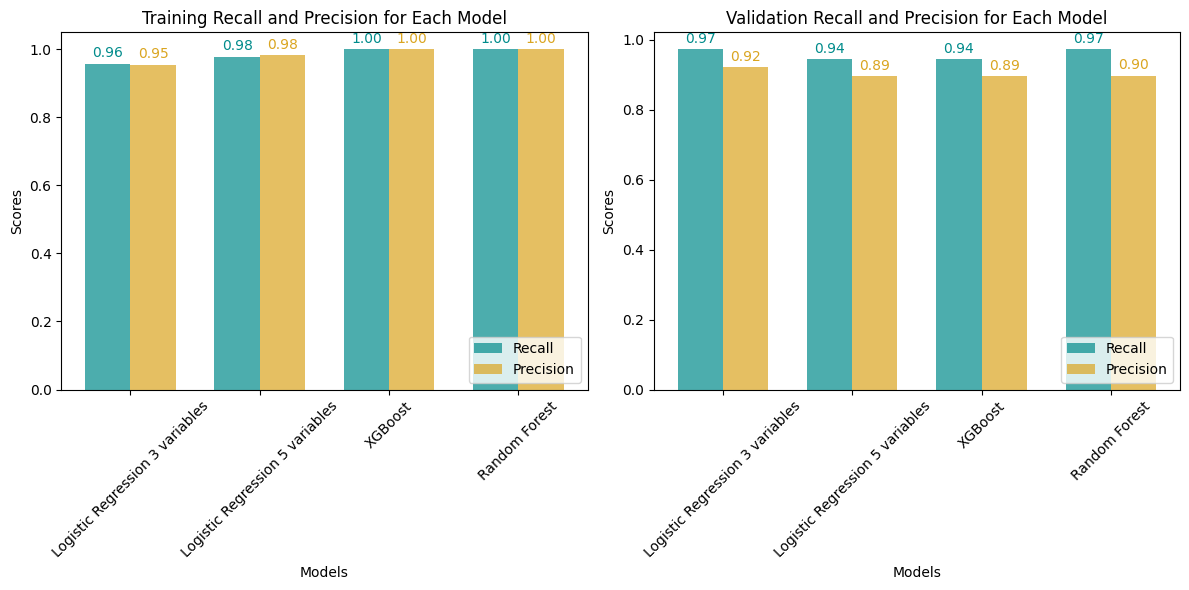

In [59]:
# Define model names
model_names = list(models.keys())

# Lists to store precision and recall values
precision_train = []
recall_train = []
precision_val = []
recall_val = []

# Iterate over each model
for model_name, model_data in models.items():
    y_train_model = model_data["y_train"]
    y_val_model = model_data["y_val"]

    # Get predictions from the results dictionary
    y_hat_train = results[model_name]["y_hat_train"]
    y_hat_val = results[model_name]["y_hat_val"]

    # Compute precision and recall for training set
    y_hat_prob_train = np.where(y_hat_train >= threshold, 1, 0)
    recall_train.append(recall_score(y_train_model.values, y_hat_prob_train))
    precision_train.append(precision_score(y_train_model.values, y_hat_prob_train))

    # Compute precision and recall for validation set
    y_hat_prob_val = np.where(y_hat_val >= threshold, 1, 0)
    recall_val.append(recall_score(y_val_model.values, y_hat_prob_val))
    precision_val.append(precision_score(y_val_model.values, y_hat_prob_val))

bar_width = 0.35
index = np.arange(len(model_names))

# Plot for training precision and recall
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(index - bar_width/2, recall_train, bar_width, label='Recall', color='darkcyan', alpha=0.7)
plt.bar(index + bar_width/2, precision_train, bar_width, label='Precision', color='goldenrod', alpha=0.7)

for i, (rec, prec) in enumerate(zip(recall_train, precision_train)):    
    plt.text(i - bar_width/2, rec + 0.01, "{:.2f}".format(rec), ha='center', va='bottom', color='darkcyan')
    plt.text(i + bar_width/2, prec + 0.01, "{:.2f}".format(prec), ha='center', va='bottom', color='goldenrod')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Training Recall and Precision for Each Model')
plt.xticks(index, model_names, rotation=45)
plt.legend(loc='lower right')

# Plot for validation precision and recall
plt.subplot(1, 2, 2)
plt.bar(index - bar_width/2, recall_val, bar_width, label='Recall', color='darkcyan', alpha=0.7)
plt.bar(index + bar_width/2, precision_val, bar_width, label='Precision', color='goldenrod', alpha=0.7)

for i, (rec, prec) in enumerate(zip(recall_val, precision_val)):
    plt.text(i - bar_width/2, rec + 0.01, "{:.2f}".format(rec), ha='center', va='bottom', color='darkcyan')
    plt.text(i + bar_width/2, prec + 0.01, "{:.2f}".format(prec), ha='center', va='bottom', color='goldenrod')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Validation Recall and Precision for Each Model')
plt.xticks(index, model_names, rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


These models perform excellent on training data, specially for XGBoost and Random Forest model.On the validation dataset, the logistic regression model with 3 variables has the highest recall and highest precision. Although Random forest has the same precision score, it drops from perfect training performance to 0.97 on validation but logistic regression model performs better than they were trained on. In our cancer detection scenario, the optimal model should achieve the balance between high recall and high precision, then the logistic regression with 3 variables is our optimal one.

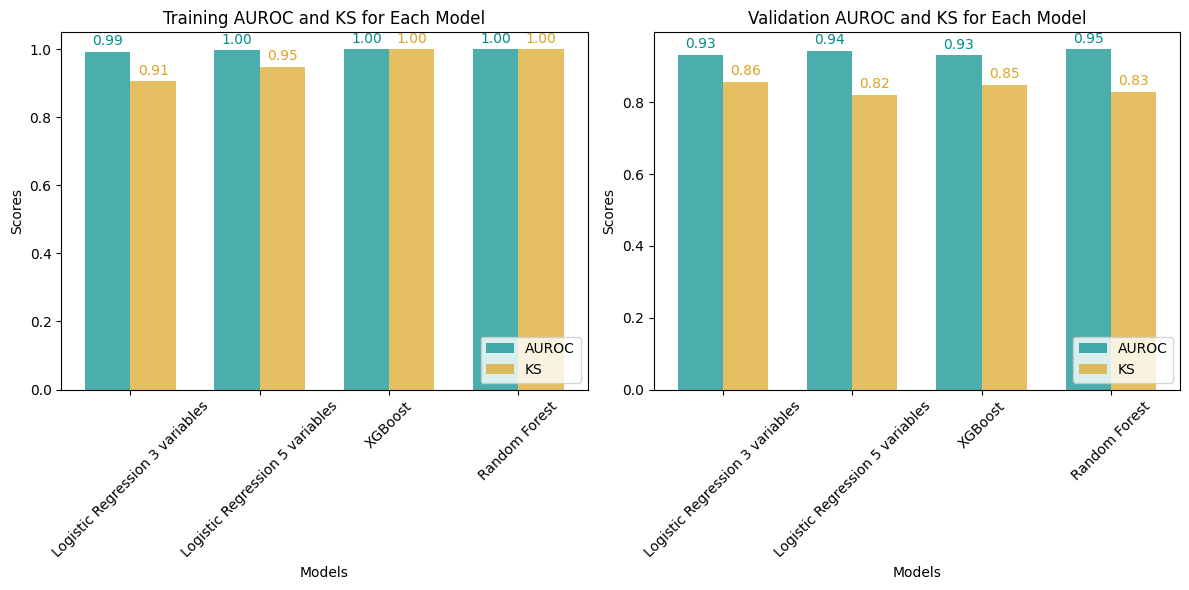

In [60]:
# Define model names
model_names = list(models.keys())

# Lists to store AUROC and KS values
auroc_train = []
ks_train = []
auroc_val = []
ks_val = []

# Iterate over each model
for model_name, model_data in models.items():
    # Get AUROC and KS statistics from the results dictionary
    auroc_train.append(results[model_name]["auroc_train"])
    ks_train.append(results[model_name]["ks_statistic_train"])
    auroc_val.append(results[model_name]["auroc_val"])
    ks_val.append(results[model_name]["ks_statistic_val"])

# Plot bars for AUROC and KS in separate plots
bar_width = 0.35
index = np.arange(len(model_names))

# Plot for training AUROC and KS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(index - bar_width/2, auroc_train, bar_width, label='AUROC', color='darkcyan', alpha=0.7)
plt.bar(index + bar_width/2, ks_train, bar_width, label='KS', color='goldenrod', alpha=0.7)

# Add score labels to AUROC and KS
for i, (auroc, ks) in enumerate(zip(auroc_train, ks_train)):
    plt.text(i - bar_width/2, auroc + 0.01, "{:.2f}".format(auroc), ha='center', va='bottom', color='darkcyan')
    plt.text(i + bar_width/2, ks + 0.01, "{:.2f}".format(ks), ha='center', va='bottom', color='goldenrod')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Training AUROC and KS for Each Model')
plt.xticks(index, model_names, rotation=45)
plt.legend(loc='lower right')

# Plot for validation AUROC and KS
plt.subplot(1, 2, 2)
plt.bar(index - bar_width/2, auroc_val, bar_width, label='AUROC', color='darkcyan', alpha=0.7)
plt.bar(index + bar_width/2, ks_val, bar_width, label='KS', color='goldenrod', alpha=0.7)

# Add score labels to AUROC and KS
for i, (auroc, ks) in enumerate(zip(auroc_val, ks_val)):
    plt.text(i - bar_width/2, auroc + 0.01, "{:.2f}".format(auroc), ha='center', va='bottom', color='darkcyan')
    plt.text(i + bar_width/2, ks + 0.01, "{:.2f}".format(ks), ha='center', va='bottom', color='goldenrod')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Validation AUROC and KS for Each Model')
plt.xticks(index, model_names, rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

On validation dataset, we know that the AUROC scores closer to 1 are indicative of model with stronger discriminative ability, so we found the random forest model has the highest AUROC score that can be considered the best at ranking the risk. And KS statistic can provide additional insight that measure the maximum difference between the CDF of the positive and negative observations. We find the model with a higher AUROC will have a lower KS, cause there are some overlap between the distribution of positive and negative classes.

Since we cannot compare model’s predictive ability from risk ranking metrics directly and cannot reflect the clinical costs of errors like recall and precision, the AUROC and KS will not be considered as the primary metrics, especially in our cancer detection scenario.

Comparing on first place the recall metric in the validation dataset, logistic regression with 3 variables is the right option based on interpretability and effectiveness. Regarding risk ranking metrics, AUROC and KS have also the highest score with the logistic regression and 3 variables.

## 8.b) Backtesting with a rebalanced data set on logistic regression 3 variables

In [61]:
##Logistic 3 variables with test
results_LR3_test = results["Logistic Regression 3 variables"]

##Precision-type metrics
y_hat_test_bal_LR3 = mdl_logistic_regression3.predict_proba(x_test_bal3)[:, 1]
y_hat_test_prob_balLR3 = np.where(y_hat_test_bal_LR3 >= threshold, 1, 0)
recall_test_bal_LR3 = recall_score(y_test_bal3.values, y_hat_test_prob_balLR3)
precision_test_bal_LR3 = precision_score(y_test_bal3.values, y_hat_test_prob_balLR3)

##Risk Ranking metrics in Training: AUROC and KS
auroc_test_bal_LR3 = roc_auc_score(y_true=y_test_bal3, y_score=y_hat_test_bal_LR3)
ks_statistic_train_bal_LR3, _ = ks_2samp(y_hat_test_bal_LR3[y_test_bal3 == 1], y_hat_test_bal_LR3[y_test_bal3 == 0])

metrics_dict = {
    "Metric": ["Recall", "Precision", "AUROC", "KS Statistic"],
    "Testing_LR3": [results_LR3_test["recall_test"], results_LR3_test["precision_test"], results_LR3_test["auroc_test"], results_LR3_test["ks_statistic_test"]],
    "Balanced_Testing_LR3": [recall_test_bal_LR3, precision_test_bal_LR3, auroc_test_bal_LR3, ks_statistic_train_bal_LR3]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df.set_index("Metric", inplace=True)

display(metrics_df)


,Testing_LR3,Balanced_Testing_LR3
Metric,,
Recall,1.000000,1.000000
Precision,0.923077,0.700000
AUROC,0.986772,0.993197
KS Statistic,0.952381,0.952381


We use the logistic regression with 3 variables model to do the final Prediction and check the performance for these 4 metrics on the testing dataset, they all look excellent, especially we got the perfect recall which means there’s no false negatives.

### Backtesting evaluation
We perform a backtesting on the model using rebalanced dataset. The original target rate is 63%, and we adjust it to 25% to reflect a more realistic scenario. The model maintains perfect recall in both datasets, which aligns with our goal to minimize false negatives. However, precision is lower in the rebalanced dataset, but it still reflects a strong predictive power. The AUROC and KS statistics both remain consistent, further confirming the model’s effectiveness and stability.

# 9.  Final Model Predictions

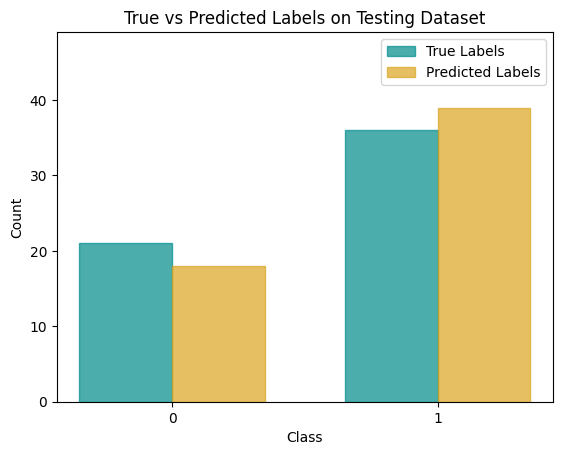

In [62]:
y_test_model = np.array(y_test_model, dtype=int)
y_hat_test_LR3 = results_LR3_test["y_hat_test"]
y_hat_test_probLR3 = np.where(y_hat_test_LR3 >= threshold, 1, 0)

# Count the occurrences of true and predicted labels for each class
true_counts = np.bincount(y_test_model)
predicted_counts = np.bincount(y_hat_test_probLR3)

# Find the maximum count for setting the range of y-axis
max_count = max(max(true_counts), max(predicted_counts))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
class_labels = [0, 1]
r1 = np.arange(len(class_labels))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, true_counts, color='darkcyan', width=bar_width, edgecolor='darkcyan', label='True Labels', alpha=0.7)
plt.bar(r2, predicted_counts, color='goldenrod', width=bar_width, edgecolor='goldenrod', label='Predicted Labels',alpha=0.7)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True vs Predicted Labels on Testing Dataset')
plt.xticks([r + bar_width/2 for r in range(len(class_labels))], class_labels)
plt.ylim(0, max_count + 10)  # Adjust the y-axis limit for better visualization
plt.legend()
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The bar chart visually shows the predictive performance on testing dataset, where it compares the count of true labels versus predicted labels. Class 0 is for negative class and Class 1 for positive class. The perfect recall leads true negatives not less than predicted negatives and true positives not greater than predicted positives. Besides, the precision value (0.923077) contributes the differences between true labels and predicted labels, some false positives finally lead true negatives greater than the predicted negatives and true positives smaller than the predicted positives.


In [63]:
df_train_mdl4 = df_train_mdl3.copy()
df_val_mdl4 = df_val_mdl3.copy()
df_test_mdl4 = df_test_mdl3.copy()

df_train_mdl4["target_result"] = np.where(results_LR3_test["y_hat_train"] >= threshold, 1, 0)
df_val_mdl4["target_result"] = np.where(results_LR3_test["y_hat_val"] >= threshold, 1, 0)
df_test_mdl4["target_result"] = np.where(results_LR3_test["y_hat_test"]>= threshold, 1, 0)

df_train_mdl4.to_csv("logistic_predictions_train.csv", index=False)
df_val_mdl4.to_csv("logistic_predictions_val.csv", index=False)
df_test_mdl4.to_csv("logistic_predictions_test.csv", index=False)

# 10. Conclusion

## Model Pipeline
We build a model pipeline for client future usage. For the pipeline, we start with features selection and input the most predictive features, and client could adjust the number and features to meet their needs. We then apply data imputation to ensure data integrity. Next, we address outliers to prevent them from skewing the model. Finally, we fit a logistic regression model with a strong regularization parameter to avoid overfitting. This pipeline automates data flow and guarantees a smooth and reproducible process for consistent results for clients.

## Discussions
We see significant potential in enhancing our model by incorporating real-world data and continuous updates. Clients are able to use model pipeline to apply the model on their own data, and update the model when there is more observations. By exploring advanced techniques, we could improve the model that not only excels in accuracy but also adapts to the evolving area of healthcare technology. For potential improvement, real-world testing will be important to ensure the practical application of our model in clinical settings. To conclude, our work contributes an effective tool to healthcare, helping early breast cancer detection. Our commitment to improvement and innovation doesn’t end here, it is an ongoing journey. We look forward to seeing this model make a meaningful impact on patient outcomes and continue to evolve with advancements in medical science and technology.